In [1]:
from ftag.hdf5 import H5Reader # I use ftag tools to read the file
from ftag import Cuts, Flavour, Flavours
from puma.hlplots import AuxResults, Tagger
from puma.utils.vertexing import calculate_vertex_metrics, build_vertices, clean_reco_vertices, clean_truth_vertices
from puma import Histogram, HistogramPlot
import numpy as np
import matplotlib.pyplot as plt

# You need to install JAX to be able to run these.
from puma.utils.billoir_vertex_fit import billoir_vertex_fit, billoir_forward
import jax.numpy as jnp


In [1]:
from puma.utils.billoir_preprocessing import ListVariables

In [2]:
def leading_jet(jet):
    return jet["jetPtRank"] == 0
    
def jet_flavour(jet, f=""):
    if f == "b": return jet["HadronConeExclTruthLabelID"] == 5
    elif f == "c": return jet["HadronConeExclTruthLabelID"] == 4
    elif f == "light": return jet["HadronConeExclTruthLabelID"] == 0
    else:  return jet ["HadronConeExclTruthLabelID"] >= 0
            


In [3]:
def MaskTracks(my_data, n_jets, n_tracks):

    n_real_tracks = np.repeat(my_data["jets"]["n_tracks"], n_tracks).reshape(n_jets, n_tracks) # This is needed because jets have a different format than tracks
    track_indices = np.tile(
         np.arange(0,n_tracks,dtype=np.int32),
         n_jets,
    ).reshape(n_jets, n_tracks)
    
    track_mask = np.where(track_indices < n_real_tracks, 1, 0)
    
    return track_mask, n_real_tracks
    
def TransformData(my_data, good_jets, n_tracks=40, drop_unrelated_hadrons = True):

    # Function to calculate the track parameters in the perigree representation.
    # Returns data x with the format n_jets x n_tracks x n_parameters
    # The n_parameters will first have the variables needed for the billoir fit, some will have to be build by hand because not everything is available

    n_jets, max_tracks = my_data["tracks"].shape

    track = my_data["tracks"][:, 0:n_tracks]
    jet = my_data["jets"][:] # Only needed if you need to calculate the track phi from dphi.

    # Start by getting a mask of the real tracks

    # Get real tracks
    track_mask, n_real_tracks = MaskTracks(my_data, n_jets, n_tracks)

    # Compute Input Variables for Billoir Vertex Fit
    ### set parameters for dummy tracks to 1. They will be masked out by the track weight and if you choose a very low value the fit will not work well.

    d0 = jnp.where(track_mask == 0, 1, -track["d0RelativeToBeamspot"])  # d0RelativeToBeamspot # NEGATIVE for Billoir fit (different definitions between ATLAS and the billoir paper)
    z0 = jnp.where(track_mask == 0, 1, track["z0RelativeToBeamspot"]) 
    
    jet_phi = jnp.repeat(jet["phi"], n_tracks).reshape(n_jets, n_tracks) # This is needed because jets have a different format than tracks
    #phi = track["phi"] # take track phi directly
    # if you calculate track phi from dphi you need the following 3 lines
    phi = jet_phi + my_data["tracks"]["dphi"]
    phi = np.where(phi < -np.pi, 2*np.pi + (jet_phi + my_data["tracks"]["dphi"]), phi)
    phi = np.where(phi > np.pi,  -2*np.pi + (jet_phi + my_data["tracks"]["dphi"]), phi)

    phi = jnp.where(track_mask == 0, 1, phi)

    theta  = jnp.where(track_mask == 0, 1, track["theta"])
    rho    = jnp.where(track_mask == 0, 1, -track["qOverP"]*2*0.2299792*0.001/jnp.sin(track["theta"])) #NEGATIVE for Billoir fit (different definitions between ATLAS and the billoir paper)

    d0_error     = jnp.where(track_mask == 0, 1, track["d0RelativeToBeamspotUncertainty"])
    z0_error     = jnp.where(track_mask == 0, 1, track["z0RelativeToBeamspotUncertainty"])

    phi_error    = jnp.where(track_mask == 0, 1, track["phiUncertainty"])
    theta_error  = jnp.where(track_mask == 0, 1, track["thetaUncertainty"])

    rho_error    = jnp.where(track_mask == 0, 1, jnp.sqrt((2*0.2299792*0.001/jnp.sin(track["theta"]) * track["qOverPUncertainty"])**2  + (track["qOverP"]*2*0.2299792*0.001/(jnp.sin(track["theta"])**2 * jnp.cos(track["theta"])) * track["thetaUncertainty"] )**2) )

    track_origin = jnp.where(track_mask == 0, 1, track["GN2v01_aux_TrackOrigin"])
    track_vertex = jnp.where(track_mask == 0, 1, track["GN2v01_aux_VertexIndex"])
     
    x = jnp.stack([d0, z0, phi, theta, rho, d0_error, z0_error, phi_error, theta_error, rho_error, track_origin, track_vertex, n_real_tracks], axis = 2)

    if drop_unrelated_hadrons == True:
        x = x[good_jets]
        track = track[good_jets]
        track_mask = track_mask[good_jets]
    return x, track, track_mask


In [4]:
def CalculateDistance(sv_x, sv_y, sv_z, pv_x, pv_y, pv_z):
    
    Lxy = np.sqrt((sv_x - pv_x)**2 + (sv_y- pv_y)**2)
    Lxyz = np.sqrt((sv_x - pv_x)**2 + (sv_y- pv_y)**2 +  (sv_z- pv_z)**2)
    return Lxy, Lxyz


# Get the vertex indices and track weights! Which tracks belong to which vertex according? The track origin is used for the cleaning
def GetTrackWeights(track_data, incl_vertexing=False, truth=False, max_sv=1):

    if truth:
        raw_vertex_index = track_data["ftagTruthVertexIndex"] # your raw vertex
        track_origin = track_data["ftagTruthOriginLabel"]

    else:
        # Reco Level
        raw_vertex_index = track_data["GN2v01_aux_VertexIndex"] # your raw vertex
        track_origin = track_data["GN2v01_aux_TrackOrigin"]

    # Now clean vertices
    vertex_index  = raw_vertex_index.copy()

    # Prepare mask for filling up
    #dummy_track_weights = jnp.zeros((vertex_index.shape[0], max_sv, n_tracks))
    track_weights = jnp.zeros((vertex_index.shape[0], max_sv, n_tracks))

    #track_weights = jnp.where(dummy_track_weights == 0, 0, dummy_track_weights) #why np.nan?
    
    for i in range(track_data["GN2v01_aux_VertexIndex"].shape[0]):

        if truth:
            vertex_index[i] = clean_truth_vertices(
                vertex_index[i], track_origin[i], incl_vertexing=incl_vertexing
            )
        
        else:
            vertex_index[i] = clean_reco_vertices(
                vertex_index[i], track_origin[i], incl_vertexing=incl_vertexing
            )

        vertices = build_vertices(vertex_index[i]) # Convert indices to true/false

        for j in range(0, max_sv):
            try:
                track_weights = track_weights.at[i, j].set(vertices[j])
            except:
                continue


    return track_weights, vertex_index


In [5]:
def ProcessTruthHadrons(my_data, n_jets):

    hadron = my_data["truth_hadrons"][:] 
    max_n_hadrons = hadron["ftagTruthParentBarcode"].shape[1]
    
    print("Max number of truth hadrons in your sample: ", max_n_hadrons)

    # Make your own loop
    child = []
    parent = []

    for i in range(0, n_jets):
        child.append(np.isin(hadron["ftagTruthParentBarcode"][i], hadron["barcode"][i]))
        parent.append(np.isin(hadron["barcode"][i], hadron["ftagTruthParentBarcode"][i]))
            
    child = np.where(hadron["ftagTruthParentBarcode"] == -1, False,np.array(child))
    parent = np.where(hadron["barcode"] == -1, False, np.array(parent))
    
    real_hadron = np.where(hadron["barcode"] == -1, False, True)
    one_hadron = np.where(np.sum(real_hadron, axis =1) ==1, True, False)

    label_hadron_index = np.where(np.sum(parent) > 0, np.argmax(parent, axis=1), np.nan)
    label_hadron_index = np.where(one_hadron == True, 0, label_hadron_index)

    child_hadron_index = np.where(np.sum(child) > 0 , np.argmax(child, axis=1), np.nan) # argmax takes the first argument from the list
    child_hadron_index = np.where(one_hadron == True, np.nan, child_hadron_index) # make sure that if there is only one hadron, the argmax does not select 0
    
    child2_hadron_index = np.full(child_hadron_index.shape, np.nan)

    for i in range (0, n_jets):
        if (np.sum(child[i]) >= 2): 
            for x in (np.argwhere(child[i] == 1)):
                if x != child_hadron_index[i]:
                    child2_hadron_index[i] = x
                else:
                    continue
            
    hadron_indices = np.stack( (label_hadron_index, child_hadron_index,  child2_hadron_index), axis = 1)

    print("Total number of jets = ", n_jets)
    n_one = np.sum(one_hadron)
    
    #family = np.where(hadron["barcode"] == -1, False, np.isin(hadron["barcode"], hadron["parentBarcode"]) | np.isin(hadron["parentBarcode"], hadron["barcode"]))
    family = np.where(hadron["barcode"] == -1, False, child | parent)
    unrelated = ((np.sum(real_hadron, axis =1) > 1) & (np.sum(family, axis =1) <= 1))

    good_jets = ((one_hadron) | (np.sum(family, axis =1) > 1))

    n_decay_chain = np.sum(np.where(np.sum(family, axis =1) > 1, True, False))
    n_unrelated = np.sum(unrelated)
    print(" -- Number of jets multiple unrelated hadrons = ",n_unrelated)

    print(" -- Number of jets with only 1 SV = ",n_one)

    print(" -- Number of jets with a decay chain = ",n_decay_chain)
    if ( n_one + n_decay_chain + n_unrelated != n_jets): 
        missing_jets = hadron[np.invert(good_jets) & np.invert(unrelated)]        
        print("The sum of the 3 types of jets does not add up to the total number of jets!")
        if (np.sum(np.where(missing_jets["pdgId"] != -1, 1, 0)) == 0): 
            if (np.sum(np.where(missing_jets["flavour"] != -1, 1, 0)) == 0):
                print("This is because for ", len(missing_jets), " non-HF jets the pdgID of all truth hadrons is -1")

        else:
            print("The reason is not understood for ", np.sum(np.where(missing_jets["pdgId"] != -1, 1, 0)), " jets and you should DEBUG this")

    print("   --> # jets with 2 SVs: = ",np.sum(np.where(np.sum(family, axis =1) == 2, True, False)))
    print("   --> # jets with 3+ SVs: = ",np.sum(np.where(np.sum(family, axis =1) > 2, True, False)))
    print("   --> # jets with 4+ SVs: = ",np.sum(np.where(np.sum(family, axis =1) > 3, True, False)))

    print(np.sum(good_jets), " good jets (= the jets with more than one unrelated hadron and light jets with no truth hadrons have been dropped )")

    
    return good_jets, hadron_indices, parent, child, one_hadron, unrelated


def GetTruthSVdisplacement(hadrons):#, hadron_indices):

    
    hadron_displacement = np.full((hadrons.shape[0], hadrons.shape[1],3), np.nan)

    for i in range(0, hadrons.shape[0]):
        for j in range(0,  hadrons.shape[1]):
            #try:
                #x = int(hadron_indices[i,j])
            #except:
            #    continue

            hadron_displacement[i,j, 0] = hadrons["displacementX"][i, j] # x -> j
            hadron_displacement[i,j, 1] = hadrons["displacementY"][i, j]
            hadron_displacement[i,j, 2] = hadrons["displacementZ"][i, j]

    return hadron_displacement




In [6]:

def AssociateTracksToHadron(my_data, good_jets, drop_bad_jets = True, debug=False):
        
    n_jets, max_tracks = my_data["tracks"].shape
    #track = my_data["tracks"][:, 0:n_tracks]
    
    # Start by getting a mask of the real tracks
    # Get real tracks
    track_mask, n_real_tracks = MaskTracks(my_data, n_jets, n_tracks)
    n_hadrons = my_data["truth_hadrons"].shape[1]
    
    if drop_unrelated_hadrons:
        my_good_jets = np.repeat(good_jets, n_tracks).reshape(n_jets, n_tracks) # This is needed because jets have a different format than tracks
        jet_track_mask = np.where(my_good_jets == True, 1, 0)
        track_mask = track_mask & jet_track_mask

    inclusive_vertex = []
    exclusive_vertex = []
    n_tracks_inclusive_vertex = []
    n_tracks_exclusive_vertex = []
    good_hadron_track_association = []

    hadron_index = []

    dummy = np.zeros(max_tracks).astype(int)

    #print(dummy)
    for i in range(0, n_jets):
        if drop_bad_jets:
            if good_jets[i] == False: continue

        #print("I am in jet ", i, " with status ", good_jets[i])
        if debug: print("Track Parent Barcodes ", my_data["tracks"]["ftagTruthParentBarcode"][i] )
        positive_track_barcodes = np.where(my_data["tracks"]["ftagTruthParentBarcode"][i] < 0, np.nan, my_data["tracks"]["ftagTruthParentBarcode"][i])
        #print(positive_track_barcodes)
        if debug: print("Hadron Barcodes ", my_data["truth_hadrons"]["barcode"][i])
        #print(np.isin(positive_track_barcodes,  my_data["truth_hadrons"]["barcode"][i]))
        inclusive_tracks_to_hadron = np.where(track_mask[i] == 0, 0, np.isin(positive_track_barcodes,  my_data["truth_hadrons"]["barcode"][i])).astype(int)        
        n_tracks_inclusive_vertex.append(np.sum(inclusive_tracks_to_hadron))
        if np.sum(inclusive_tracks_to_hadron) <= 1: 
            #print("adding dummy zeros for i ", i)
            inclusive_vertex.append(dummy)
        else:
            inclusive_vertex.append(inclusive_tracks_to_hadron)        
        
        #print(inclusive_vertex[-1])
        tmp_exclusive_list = []
        tmp_n_tracks = []
        for j in range(0, n_hadrons):
            tmp_exclusive = np.where(track_mask[i] == 0, 0, np.isin(positive_track_barcodes,  my_data["truth_hadrons"]["barcode"][i][j])).astype(int)        
            if np.sum(tmp_exclusive) <= 1:    
                
                tmp_exclusive_list.append(dummy)
            else:
                tmp_exclusive_list.append(tmp_exclusive)
            tmp_n_tracks.append(int(np.sum(tmp_exclusive_list[-1])))
        n_tracks_exclusive_vertex.append(tmp_n_tracks)
    
        if np.sum(n_tracks_exclusive_vertex[-1]) > 0:        
            hadron_index.append(np.argmax(n_tracks_exclusive_vertex[-1]))
            good_hadron_track_association.append(1)
        else:
            hadron_index.append(-99) # None of the hadron indices have 2 associated trakcks
            good_hadron_track_association.append(0)

        #print(np.sum(tmp_exclusive_list, axis=1))
        #hadron_with_most_tracks = np.argmax(np.sum(tmp_exclusive_list, axis=2), axis=1)
        #hadron_index.append()

        exclusive_vertex.append(np.array(tmp_exclusive_list)) 

        if debug: print("INCLUSIVE Track to Hadron Association ", inclusive_vertex[-1])
        if debug: print("EXCLUSIVE Track to Hadron Association ", exclusive_vertex[-1])
        if debug: print("Index for Hadron with highest amoutn of associated tracks ", hadron_index[-1])
        if debug: print("Number of tracks associated to the each hadron ", n_tracks_per_hadron[-1])
        
    inclsuive_vertex = np.array(inclusive_vertex)
    exclusive_vertex = np.array(exclusive_vertex)
    hadron_index = np.array(hadron_index)

    
    return inclusive_vertex, exclusive_vertex, hadron_index, n_tracks_inclusive_vertex, n_tracks_exclusive_vertex, track_mask, jet_track_mask, good_hadron_track_association


In [7]:
def GetCuts(sample):

    if sample == "ttbar":
        sample_str = "$t\\overline{t}$"
        cuts = [
            ("pt", ">=", 20000),
            ("pt", "<=", 250000),
            ("eta", ">", -2.5),
            ("eta", "<", 2.5),
            ("HadronConeExclTruthLabelID", ">=", 0), # 0 for light, 4 for c, 5 for b single b-tagged
            ("HadronConeExclTruthLabelID", "<=", 5),
            #("jetPtRank", "==", 0)

        ]
        cut_str = "20 < $p_T$ < 250 GeV, $|\\eta| < 2.5$"
            
    elif sample == "zprime":
        sample_str = "Z'"
        cuts = [
            ("pt", ">=", 250000),
            ("pt", "<=", 6000000),
            ("eta", ">", -2.5),
            ("eta", "<", 2.5),
            #("HadronConeExclTruthLabelID", ">=", 4),
            #("HadronConeExclTruthLabelID", "<=", 5)

        ]
        cut_str = "250 < $p_T$ < 6000 GeV, $|\\eta| < 2.5$"
    

    return cuts, cut_str



In [8]:
import h5py

def ListVariables(file):
    with h5py.File(file_path, "r") as f:
        print(f.keys())
        for k in list(f.keys()):
            print(k)
            print(f[k].dtype.fields.keys())

    return 

In [9]:
### Read your data!

    sample = "ttbar"
    mc = "MC23a"
    #my_dir = "GN2_NDIVE/" #"GN2_NDIVE/" "Downloaded/"#
    my_dir = "OpenDataset_final/"
    output = "FinalPlots/"
    
    n_jets = 400000 #150000
    n_tracks = 40 # max 40
    
    ## Choose what to read
    file_path =  "/fs/ddn/sdf/group/atlas/d/lapereir/GN2/"+my_dir+"/"+mc_c+"_"+"new-"+sample+".h5"
    print(file_path)
    
    # If you need to print out the containers and variables in your file
    ListVariables(file_path)
    
    my_cuts, cut_str = GetCuts(sample)
    
    
    track_var = ["d0", "z0SinTheta", "dphi", "d0Uncertainty", "z0SinThetaUncertainty", "phiUncertainty", "thetaUncertainty", "qOverPUncertainty", "qOverP", "deta", "theta", "dphi"] # for vertex fit
    track_var += ["d0RelativeToBeamspot", "d0RelativeToBeamspotUncertainty","z0RelativeToBeamspot", "z0RelativeToBeamspotUncertainty",  "ftagTruthOriginLabel",  "GN2v01_aux_TrackOrigin", "GN2v01_aux_VertexIndex",  "ftagTruthVertexIndex", "ftagTruthParentBarcode"]
    track_var += ["JFVertexIndex"]
    
    jet_var = ["eventNumber","GN2v01_pb", "GN2v01_pc", "GN2v01_pu", "n_tracks", "jetPtRank", "phi", "eta", "HadronConeExclTruthLabelID", "HadronConeExclExtendedTruthLabelID", "HadronConeExclTruthLabelPdgId", "HadronConeExclTruthLabelLxy", "SV1_Lxy", "JetFitterSecondaryVertex_displacement2d", "SV1_L3d", "JetFitterSecondaryVertex_displacement3d", "JetFitter_nVTX", "mcEventWeight", "nPrimaryVertices"] # phi is needed for vertex fit if track phi is not available # v00 instead of v01
    jet_var +=['primaryVertexToBeamDisplacementX', 'primaryVertexToBeamDisplacementY', 'primaryVertexToBeamDisplacementZ', 'primaryVertexToTruthVertexDisplacementX', 'primaryVertexToTruthVertexDisplacementY', 'primaryVertexToTruthVertexDisplacementZ', 'truthPrimaryVertexX', 'truthPrimaryVertexY', 'truthPrimaryVertexZ', 'primaryVertexDetectorZ']
    jet_var += ['JetFitterSecondaryVertex_nTracks', 'JetFitter_nTracksAtVtx']
    truth_hadrons = ['pt', 'mass', 'energy', 'eta', 'phi', 'deta', 'dphi', 'dr', 'displacementX', 'displacementY', 'displacementZ','Lxy', 'charge', 'flavour', 'pdgId', 'barcode', 'ftagTruthParentBarcode', 'valid',  'decayVertexDPhi', 'decayVertexDEta'] # parentBarcode
    
    kinematic_cuts = Cuts.from_list(my_cuts)
    print(kinematic_cuts)
    
    ## read it!
    my_reader = H5Reader(file_path, precision="full", shuffle=False, batch_size=100)
    my_data = my_reader.load({"jets": jet_var, "tracks" : track_var, "truth_hadrons" : truth_hadrons}, num_jets=n_jets, cuts=kinematic_cuts)
#my_data = my_reader.load({"jets": ["phi"], "tracks" : ["dphi", "phi"]}, num_jets=n_jets, cuts=kinematic_cuts)

#my_data = my_reader.load({"jets": jet_var, "tracks" : track_var, "ConeExclFinalLabels" : truth_hadrons, "truth_hadrons" : truth_hadrons}, cuts=kinematic_cuts)

#my_data = my_reader.load({"jets": jet_var, "tracks" : track_var}, cuts=kinematic_cuts,  num_jets=n_jets) # "ConeExclFinalLabels" : truth_hadrons}, cuts=kinematic_cuts) # num_jets=n_jets,


# now you will be able to read 
# --- data["jets"] with shape n_jets (x n_jet_var tuple)
# --- data["tracks"] with shape n_jets x n_tracks (x n_track_var tuple)
# Note that since jet_var and track_var are stored in a tuple instead of an array when using H5Reader, therefore you will need to convert them to arrays in order to run NDIVE!


/fs/ddn/sdf/group/atlas/d/lapereir/GN2/OpenDataset_final//MC23a_new-ttbar.h5
<KeysViewHDF5 ['ConeExclFinalLabels', 'jets', 'tracks', 'truth_hadrons']>
ConeExclFinalLabels
dict_keys(['charge', 'flavour', 'pdgId', 'barcode', 'ftagTruthParentBarcode', 'pt', 'mass', 'energy', 'eta', 'phi', 'deta', 'dphi', 'dr', 'displacementX', 'displacementY', 'displacementZ', 'Lxy', 'decayVertexDPhi', 'decayVertexDEta', 'valid'])
jets
dict_keys(['GN2v01_pb', 'GN2v01_pc', 'GN2v01_pu', 'GN2v01_ptau', 'SV1_correctSignificance3d', 'softMuon_pt', 'softMuon_dR', 'softMuon_eta', 'softMuon_phi', 'softMuon_qOverPratio', 'softMuon_momentumBalanceSignificance', 'softMuon_scatteringNeighbourSignificance', 'softMuon_pTrel', 'softMuon_ip3dD0', 'softMuon_ip3dZ0', 'softMuon_ip3dD0Significance', 'softMuon_ip3dZ0Significance', 'softMuon_ip3dD0Uncertainty', 'softMuon_ip3dZ0Uncertainty', 'JetFitterFlip_energyFraction', 'JetFitterFlip_mass', 'JetFitterFlip_significance3d', 'JetFitterFlip_deltaphi', 'JetFitterFlip_deltaeta', 

Plotting GN2v01_aux_TrackOrigin vs ftagTruthOriginLabel 


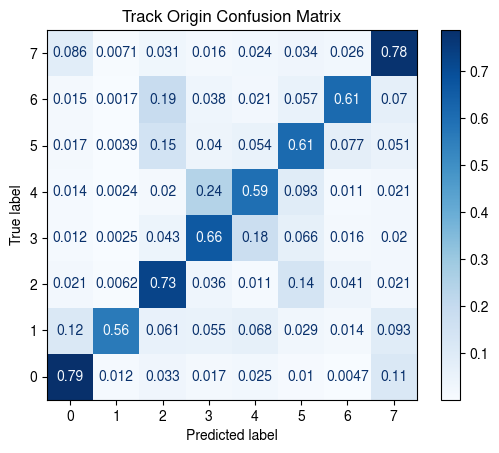

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


print("Plotting GN2v01_aux_TrackOrigin vs ftagTruthOriginLabel ")

# Sample input arrays
true_labels = my_data["tracks"]["ftagTruthOriginLabel"]
pred_labels = my_data["tracks"]["GN2v01_aux_TrackOrigin"]

# Filter out -1 values
mask = true_labels != -1
true_labels_filtered = true_labels[mask]
pred_labels_filtered = pred_labels[mask]

# Flatten the arrays
true_labels_flat = true_labels_filtered.flatten()
pred_labels_flat = pred_labels_filtered.flatten()


# Compute the confusion matrix
cm = confusion_matrix(true_labels_flat, pred_labels_flat, normalize='true')

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(0, 8))
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)

# Invert the y-axis
ax.invert_yaxis()

plt.title('Track Origin Confusion Matrix')
plt.savefig(output+"TrackOriginConfusionMatric.png")

In [10]:
drop_unrelated_hadrons = True
good_jets, hadron_indices, parent, child, one_hadron, unrelated = ProcessTruthHadrons(my_data, my_data["jets"].shape[0])

# Associate Tracks to Truth Hadrons
inclusive_track_vertex, exclusive_track_vertex, index_hadron_most_tracks, n_tracks_inclusive_vertex, n_tracks_exclusive_vertex, vertex_track_mask, good_jet_mask, good_hadron_track_association_mask = AssociateTracksToHadron(my_data, good_jets, drop_bad_jets=True)
index_hadron_most_tracks_positive = np.where(index_hadron_most_tracks == -99, 0, index_hadron_most_tracks) 

# How does the selected hadron change when requiring leading (labeling) jet or the jet with highest tracks?
lead_hadron = hadron_indices[good_jets][:,0]
labeling_hadron_has_most_tracks = np.equal(lead_hadron, index_hadron_most_tracks)

print(" ----------------------------------- ")
print("For ", np.sum(labeling_hadron_has_most_tracks)/len(labeling_hadron_has_most_tracks)*100, "% of the jets, the leading hadron is also the one with highest amount of tracks")
#print("Out of those, only ", np.sum(lead_hadron[labeling_hadron_has_most_tracks])/len(parent_hadron_not_most_tracks)*100, " %  do not choose the leading hadron")

jets = my_data["jets"][good_jets]

Max number of truth hadrons in your sample:  5
Total number of jets =  400000
 -- Number of jets multiple unrelated hadrons =  2687
 -- Number of jets with only 1 SV =  40642
 -- Number of jets with a decay chain =  155888
The sum of the 3 types of jets does not add up to the total number of jets!
This is because for  200783  non-HF jets the pdgID of all truth hadrons is -1
   --> # jets with 2 SVs: =  115381
   --> # jets with 3+ SVs: =  40507
   --> # jets with 4+ SVs: =  1858
196530  good jets (= the jets with more than one unrelated hadron and light jets with no truth hadrons have been dropped )
 ----------------------------------- 
For  46.303363354195284 % of the jets, the leading hadron is also the one with highest amount of tracks


In [ ]:

n_tracks_exclusive_vertex = np.array(n_tracks_exclusive_vertex)
max_tracks = np.max(n_tracks_exclusive_vertex, axis=1)

k = 0
for i in range(n_tracks_exclusive_vertex.shape[0]):
    my_jet = n_tracks_exclusive_vertex[i, :]
    if max_tracks[i] > 0:
        n_hadron_max = np.sum(np.where(my_jet == max_tracks[i], 1, 0))
        if n_hadron_max >1:
            k +=1
            #print(n_hadron_max, " hadrons in ", my_jet)
            #print(" -> chosen index ", index_hadron_most_tracks[i])
print(k)

In [52]:
hadrons_with_multiple_tracks = []

index_candidates = []

for i in range(n_tracks_exclusive_vertex.shape[0]):
    my_jet = n_tracks_exclusive_vertex[i, :]

    n_hadrons = 0
    index_hadrons = []
    for h in range(0,5):
        #print(h)
        if my_jet[h] >= 2:
            n_hadrons += 1
            index_hadrons.append(h)
        else:
            index_hadrons.append(np.nan)

    #print(n_hadrons)
    #print(index_hadrons)
    hadrons_with_multiple_tracks.append(n_hadrons)
    index_candidates.append(index_hadrons)
            


In [68]:
hadrons_with_multiple_tracks = np.array(hadrons_with_multiple_tracks)
index_candidates = np.array(index_candidates)

print(np.sum(np.where(hadrons_with_multiple_tracks > 2, 1, 0)))


NameError: name 'hadrons_with_multiple_tracks' is not defined

[ 1. nan nan ... nan  1.  1.]


/lscratch/lapereir/tmp/ipykernel_354632/2395782151.py:30: RuntimeWarning: invalid value encountered in cast
  n_tracks_vertex2 = n_tracks_exclusive_vertex[mask_child1][np.arange(len(n_tracks_exclusive_vertex[mask_child1])), (child1_hadron.astype(int))[mask_child1]]
/lscratch/lapereir/tmp/ipykernel_354632/2395782151.py:31: RuntimeWarning: invalid value encountered in cast
  n_tracks_vertex3 = n_tracks_exclusive_vertex[mask_child2][np.arange(len(n_tracks_exclusive_vertex[mask_child2])), (child2_hadron.astype(int))[mask_child2]]


0
0
0


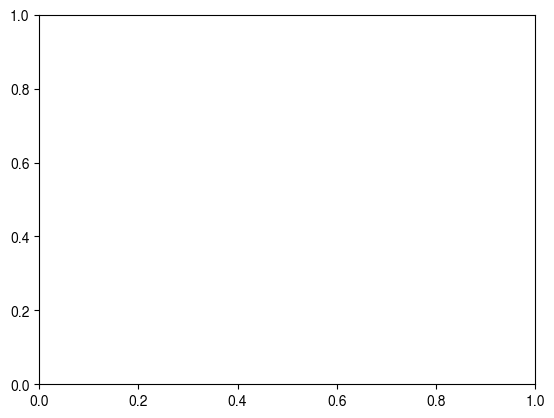

In [47]:
# inclusive
n_inclusive_tracks = np.array(n_tracks_inclusive_vertex)

# exclusive 
n_tracks_exclusive_vertex = np.array(n_tracks_exclusive_vertex)

# - hadron with most tracks - 
tmp_most_track_index = np.where(index_hadron_most_tracks == -99, 0, index_hadron_most_tracks) 
n_exclusive_most_tracks = n_tracks_exclusive_vertex[np.arange(len(n_tracks_exclusive_vertex)), tmp_most_track_index]

# - labeling hadron - 
n_exclusive_label_tracks = n_tracks_exclusive_vertex[np.arange(len(n_tracks_exclusive_vertex)), (lead_hadron.astype(int))]

child1_hadron = hadron_indices[good_jets][:,1]

mask_child1 = np.invert(np.isnan(child1_hadron))
print(child1_hadron)

child2_hadron = hadron_indices[good_jets][:,2]
mask_child2 = np.invert(np.isnan(child2_hadron))



my_filter = np.where(n_exclusive_most_tracks >=2, 1, 0) & mask_child1


#print(my_filter)

n_tracks_vertex1 = n_exclusive_label_tracks
n_tracks_vertex2 = n_tracks_exclusive_vertex[mask_child1][np.arange(len(n_tracks_exclusive_vertex[mask_child1])), (child1_hadron.astype(int))[mask_child1]]
n_tracks_vertex3 = n_tracks_exclusive_vertex[mask_child2][np.arange(len(n_tracks_exclusive_vertex[mask_child2])), (child2_hadron.astype(int))[mask_child2]]
#print(n_true_tracks)
#print(n_reco_sv_tracks)
#print(n_truth_sv_tracks)


normalise = False
y_axis = "Number of jets"
my_extra = " Truth Level "
extra_string = ""
if normalise: 
    extra_string = "_norm"
    y_axis = "Arbitrary Units"

for flavour in ["bjets", "cjets", "light"]:

    # Choose selection
    if flavour == "all":
        f = ""
        flav_str = "(all flavours)"
    
    if flavour == "bjets":
        f = "b"
        flav_str = "(b-jets)"
    
    if flavour == "cjets":
        f = "c"
        flav_str = "(c-jets)"
    
    if flavour == "light":
        f = "light"
        flav_str = "(light jets)"
    

    selection = jet_flavour(jets, f) & my_filter
        
    h_i = Histogram( n_inclusive_tracks[selection], label="Inclusive Vertex", histtype="step", alpha=1)    
    h_ex_l = Histogram( n_exclusive_label_tracks[selection], label="Exclusive Vertex (Labeling Hadron)", histtype="step", alpha=1)    
    h_ex_m = Histogram( n_exclusive_most_tracks[selection], label="Exclusive Vertex (Hadron with most tracks)", histtype="step", alpha=1)    

    h_ex_1 = Histogram( n_tracks_vertex1[selection], label="Childless or Parent", histtype="step", alpha=1)    
    h_ex_2 = Histogram( n_tracks_vertex2[jet_flavour(jets, f)[mask_child1]], label="First Child", histtype="step", alpha=1)    
    h_ex_3 = Histogram( n_tracks_vertex3[jet_flavour(jets, f)[mask_child2]], label="Second Child", histtype="step", alpha=1)    
    

    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel=y_axis,
        xlabel="Number of Tracks in Vertex",
        logy=False,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=8,  # you can also define an integer number for the number of bins
        bins_range=(0,8),  # only considered if bins is an integer
        norm=normalise,
        atlas_first_tag="Simulation Internal ",
        atlas_second_tag=mc+" "+sample+" "+flav_str+my_extra,
        figsize=(6, 5),
        n_ratio_panels=0,
    )

    #plot_histo.add(h_i, reference=False)
    #plot_histo.add(h_ex_l, reference=False)
    #plot_histo.add(h_ex_m, reference=True)

    #plot_histo.add(h_ex_1, reference=False)
    plot_histo.add(h_ex_2, reference=False)
    plot_histo.add(h_ex_3, reference=False)

    plot_histo.draw()
    
    plot_histo.savefig(output+"Histogram_True_nTracksVertex_Family_"+flavour+extra_string+".png", transparent=False)



print(np.sum(np.isnan(n_exclusive_most_tracks)))
print(np.sum(np.isnan(n_exclusive_label_tracks)))
print(np.sum(np.isnan(n_inclusive_tracks)))

In [11]:
truth_displacement_hadrons = GetTruthSVdisplacement(my_data["truth_hadrons"][good_jets])

# A) Select the leading hadron according to the hadron_indices variable i.e. the parent if there is a decay
LeadHadron_Truth_displacement = truth_displacement_hadrons[np.arange(truth_displacement_hadrons.shape[0]),np.array(lead_hadron).astype(int)]

# B) Select the hadron with most tracks (this requires some cleaning) 

def TruthDisplacement_HadronMostTracks(truth_hadron_displacement, index_hadron_most_tracks):
    # change -99 to 0 so that you can do the association later  
    tmp_index = np.where(index_hadron_most_tracks == -99, 0, index_hadron_most_tracks) 
    # Get the displacement of the hadron with most tracks (including 0 for those with no tracks)
    MostTrackHadron_Truth_displacement = truth_hadron_displacement[np.arange(truth_hadron_displacement.shape[0]), tmp_index] 
    # Mask the jets with no associated tracks to include the 3 coordinates
    truth_hadron_displacement_mask = np.repeat(good_hadron_track_association_mask, 3).reshape(len(good_hadron_track_association_mask),3)

    # Remove jets with no tracks from your truth displacement variables!
    MostTrackHadron_Truth_displacement = np.where(truth_hadron_displacement_mask == 0, np.nan, MostTrackHadron_Truth_displacement)

    return MostTrackHadron_Truth_displacement
    
MostTrackHadron_Truth_displacement = TruthDisplacement_HadronMostTracks(truth_displacement_hadrons, index_hadron_most_tracks)



Total # jets: b, c, light
158083
33990
4457
Total =  196530
Good # jets (not NaN): b, c, light
137250  ( 86.82147985551893 % )
23429  ( 68.92909679317447 % )
549  ( 12.317702490464438 % )
Total =  161228
Fraction of jets with displacement in the (x,y,z) index =  0 , below of  1  mm : b, c, light
29.95992714025501 %
54.33010371761492 %
73.224043715847 %


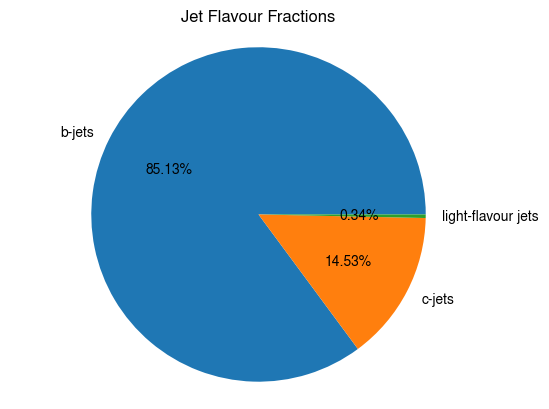

In [12]:
# Let's study the flavor fractions in our dataset!

#TrueDisp = LeadHadron_Truth_displacement
TrueDisp = MostTrackHadron_Truth_displacement

bjets = TrueDisp[jet_flavour(jets, "b")]
cjets = TrueDisp[jet_flavour(jets, "c")]
light_jets = TrueDisp[jet_flavour(jets, "light")]

index = 0 # 0 for X, 1 for Y and 2 for Z
l = light_jets[:,index]
b = bjets[:,index]
c = cjets[:,index]

thres = 1

print("Total # jets: b, c, light")
print(len(bjets))
print(len(cjets))
print(len(light_jets))
print("Total = ", len(bjets) + len(cjets) + len(light_jets))

non_zero_b = (len(b) - np.sum(np.isnan(b)))
non_zero_c = (len(c) - np.sum(np.isnan(c)))
non_zero_l = (len(l) - np.sum(np.isnan(l)))

non_zero_total = non_zero_b+non_zero_c+non_zero_l
print("Good # jets (not NaN): b, c, light")
print(non_zero_b, " (", non_zero_b/len(b)*100, "% )")
print(non_zero_c, " (", non_zero_c/len(c)*100, "% )")
print(non_zero_l, " (", non_zero_l/len(l)*100, "% )")

fractions = [non_zero_b/non_zero_total,non_zero_c/non_zero_total, non_zero_l/non_zero_total ]
labels = ["b-jets", "c-jets", "light-flavour jets"]
# Creating the pie chart
plt.pie(fractions, labels=labels, autopct='%1.2f%%')

# Equal aspect ratio ensures the pie chart is circular
plt.axis('equal')
plt.title("Jet Flavour Fractions")
# Display the chart
plt.savefig(output+"JetFlavourFractions.png")

print("Total = ", non_zero_b+non_zero_c+non_zero_l) 

array_b = np.abs(b[np.invert(np.isnan(b))])
array_c = np.abs(c[np.invert(np.isnan(c))])
array_l = np.abs(l[np.invert(np.isnan(l))])


print("Fraction of jets with displacement in the (x,y,z) index = ", index,", below of ", thres, " mm : b, c, light")

print(np.sum(array_b < thres)/non_zero_b*100, "%")
print(np.sum(array_c < thres)/non_zero_c*100, "%")
print(np.sum(array_l < thres)/non_zero_l*100, "%")

Lead Hadron Lxy  0  of  98575 ( 0.0 %) are NaN
Hadron with most tracks  17633  of  98575 ( 17.887902612224195 %) are NaN
HadronConeExclTruthLabelLxy  2257  of  98575 ( 2.2896271874207454 %) are NaN


/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),


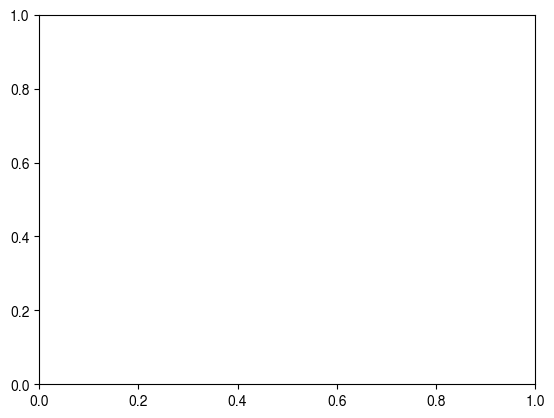

In [224]:
# Residual with pre-existing Truth Lxy variable

LeadHadron_Lxy = np.sqrt(LeadHadron_Truth_displacement[:,0]**2 + LeadHadron_Truth_displacement[:,1]**2)
MostTrackHadron_Lxy = np.sqrt(MostTrackHadron_Truth_displacement[:,0]**2 + MostTrackHadron_Truth_displacement[:,1]**2)
Ftag_Lxy = jets["HadronConeExclTruthLabelLxy"]

print("Lead Hadron Lxy ", np.sum(np.isnan(LeadHadron_Lxy)), " of ", len(LeadHadron_Lxy), "(", np.sum(np.isnan(LeadHadron_Lxy))/len(LeadHadron_Lxy)*100,"%) are NaN")
print("Hadron with most tracks ",np.sum(np.isnan(MostTrackHadron_Lxy)), " of ", len(MostTrackHadron_Lxy), "(", np.sum(np.isnan(MostTrackHadron_Lxy))/len(MostTrackHadron_Lxy)*100,"%) are NaN")
print("HadronConeExclTruthLabelLxy ", np.sum(np.isnan(Ftag_Lxy))," of ", len(Ftag_Lxy), "(", np.sum(np.isnan(Ftag_Lxy))/len(Ftag_Lxy)*100,"%) are NaN")

normalise = False
extra_string = ""
y_axis = "Number of events"
if normalise: 
    extra_string = "_norm"
    y_axis = "Arbitrary Units"

for flavour in ["bjets", "cjets", "light"]:

    # Choose selection
    if flavour == "all":
        f = ""
        flav_str = "(all flavours)"
    
    if flavour == "bjets":
        f = "b"
        flav_str = "(b-jets)"
    
    if flavour == "cjets":
        f = "c"
        flav_str = "(c-jets)"
    
    if flavour == "light":
        f = "light"
        flav_str = "(light jets)"
    
    
    #expectation_hist = Histogram(vertex_metrics["n_match"][is_flavour], label="n match", histtype="stepfilled", alpha=1)
    
    # the variable needs to be an array

    hist_l =  Histogram(LeadHadron_Lxy[jet_flavour(jets, f) ], label="Labeling Hadron", histtype="step", alpha=1)  
    hist_m =  Histogram(MostTrackHadron_Lxy[jet_flavour(jets, f) ], label="Hadron with most tracks", histtype="step", alpha=1)  
    hist_f = Histogram(Ftag_Lxy[jet_flavour(jets, f) ], label="HadronConeExclTruthLabelLxy", histtype="step", alpha=1)  
        
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel=y_axis,
        xlabel="Lxy [mm]",
        logy=False,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=20,  # you can also define an integer number for the number of bins
        bins_range=(0,40),  # only considered if bins is an integer
        norm=normalise,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str,
        figsize=(6, 5),
        n_ratio_panels=1,
    )
    
    plot_histo.add(hist_f, reference=True)
    plot_histo.add(hist_m, reference=False)
    plot_histo.add(hist_l, reference=False)
    
    
    plot_histo.draw()
    plot_histo.savefig(output+"Histogram_Truth_Lxy_"+flavour+extra_string+".png", transparent=False)


In [242]:
#TrueDisp = LeadHadron_Truth_displacement
TrueDisp = MostTrackHadron_Truth_displacement

Truth_Displacement_x = TrueDisp[:, 0] 
Truth_Displacement_y = TrueDisp[:, 1] 
Truth_Displacement_z =TrueDisp[:, 2]

Truth_Lxy = np.sqrt( Truth_Displacement_x**2 + Truth_Displacement_y**2)
Truth_Lxyz = np.sqrt( Truth_Displacement_x**2 + Truth_Displacement_y**2 + Truth_Displacement_z**2)

#basic_extra_string  += "_LabelingTruth"

/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid v

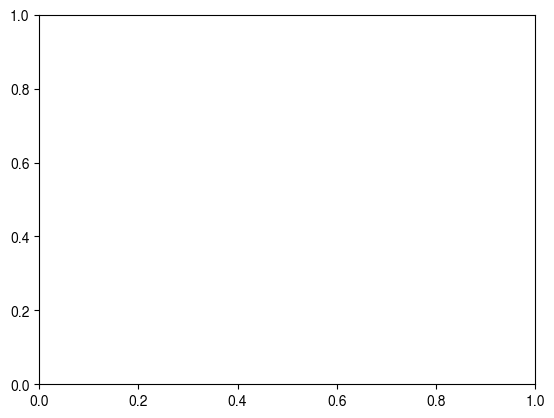

In [169]:
# Let's plot the truth SV displacement for the different flavors

Truth_Displacement_x = TrueDisp[:, 0] 
Truth_Displacement_y = TrueDisp[:, 1] 
Truth_Displacement_z =TrueDisp[:, 2]

Truth_Lxy = np.sqrt( Truth_Displacement_x**2 + Truth_Displacement_y**2)
Truth_Lxyz = np.sqrt( Truth_Displacement_x**2 + Truth_Displacement_y**2 + Truth_Displacement_z**2)

normalise = True
y_axis = "Number of events"
extra_string = ""
if normalise: 
    extra_string = "_norm"
    y_axis = "Arbitrary Units"

flav_str = "(all flavours)"    


truth_l = Histogram( Truth_Displacement_x[jet_flavour(jets, "light")], label="Light", histtype="step", alpha=1)    
truth_c = Histogram( Truth_Displacement_x[jet_flavour(jets, "c")], label="c", histtype="step", alpha=1)    
truth_b = Histogram( Truth_Displacement_x[jet_flavour(jets, "b")], label="b", histtype="step", alpha=1)    

    
# Initialise histogram plot
plot_histo = HistogramPlot(
        ylabel=y_axis,
        xlabel="Truth SV Displacement X",
        logy=False,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=19,  # you can also define an integer number for the number of bins
        bins_range=(-9.5,9.5),  # only considered if bins is an integer
        norm=normalise,
        atlas_first_tag="Simulation Internal ",
        atlas_second_tag=mc+" "+sample+" "+flav_str,
        figsize=(6, 5),
        n_ratio_panels=1,
)

plot_histo.add(truth_l, reference=True)
plot_histo.add(truth_c, reference=False)
plot_histo.add(truth_b, reference=False)
    
plot_histo.draw()
    
plot_histo.savefig(output+"Histogram_Truth_Vertex_X_all_flavors"+extra_string+".png", transparent=False)

truth_l = Histogram( Truth_Displacement_y[jet_flavour(jets, "light")], label="Light", histtype="step", alpha=1)    
truth_c = Histogram( Truth_Displacement_y[jet_flavour(jets, "c")], label="c", histtype="step", alpha=1)    
truth_b = Histogram( Truth_Displacement_y[jet_flavour(jets, "b")], label="b", histtype="step", alpha=1)    

    
# Initialise histogram plot
plot_histo = HistogramPlot(
        ylabel=y_axis,
        xlabel="Truth SV Displacement Y",
        logy=False,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=19,  # you can also define an integer number for the number of bins
        bins_range=(-9.5,9.5),  # only considered if bins is an integer
        norm=normalise,
        atlas_first_tag="Simulation Internal ",
        atlas_second_tag=mc+" "+sample+" "+flav_str,
        figsize=(6, 5),
        n_ratio_panels=1,
)

plot_histo.add(truth_l, reference=True)
plot_histo.add(truth_c, reference=False)
plot_histo.add(truth_b, reference=False)
    
plot_histo.draw()
    
plot_histo.savefig(output+"Histogram_Truth_Vertex_Y_all_flavors"+extra_string+".png", transparent=False)


truth_l = Histogram( Truth_Displacement_z[jet_flavour(jets, "light")], label="Light", histtype="step", alpha=1)    
truth_c = Histogram( Truth_Displacement_z[jet_flavour(jets, "c")], label="c", histtype="step", alpha=1)    
truth_b = Histogram( Truth_Displacement_z[jet_flavour(jets, "b")], label="b", histtype="step", alpha=1)    

    
# Initialise histogram plot
plot_histo = HistogramPlot(
        ylabel=y_axis,
        xlabel="Truth SV Displacement Z",
        logy=False,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=19,  # you can also define an integer number for the number of bins
        bins_range=(-9.5,9.5),  # only considered if bins is an integer
        norm=normalise,
        atlas_first_tag="Simulation Internal ",
        atlas_second_tag=mc+" "+sample+" "+flav_str,
        figsize=(6, 5),
        n_ratio_panels=1,
)

plot_histo.add(truth_l, reference=True)
plot_histo.add(truth_c, reference=False)
plot_histo.add(truth_b, reference=False)
    
plot_histo.draw()
    
plot_histo.savefig(output+"Histogram_Truth_Vertex_Z_all_flavors"+extra_string+".png", transparent=False)


truth_l = Histogram( Truth_Lxy[jet_flavour(jets, "light")], label="Light", histtype="step", alpha=1)    
truth_c = Histogram( Truth_Lxy[jet_flavour(jets, "c")], label="c", histtype="step", alpha=1)    
truth_b = Histogram( Truth_Lxy[jet_flavour(jets, "b")], label="b", histtype="step", alpha=1)    

    
# Initialise histogram plot
plot_histo = HistogramPlot(
        ylabel=y_axis,
        xlabel="Truth SV Displacement Lxy",
        logy=False,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=48,  # you can also define an integer number for the number of bins
        bins_range=(0,24),  # only considered if bins is an integer
        norm=normalise,
        atlas_first_tag="Simulation Internal ",
        atlas_second_tag=mc+" "+sample+" "+flav_str,
        figsize=(6, 5),
        n_ratio_panels=1,
)

plot_histo.add(truth_l, reference=True)
plot_histo.add(truth_c, reference=False)
plot_histo.add(truth_b, reference=False)
    
plot_histo.draw()
    
plot_histo.savefig(output+"Histogram_Truth_Lxy_all_flavors"+extra_string+".png", transparent=False)

res = jets["SV1_Lxy"] - Truth_Lxy

res_l = Histogram( res[jet_flavour(jets, "light")], label="Light", histtype="step", alpha=1)    
res_c = Histogram( res[jet_flavour(jets, "c")], label="c", histtype="step", alpha=1)    
res_b = Histogram( res[jet_flavour(jets, "b")], label="b", histtype="step", alpha=1)    

    
# Initialise histogram plot
plot_histo = HistogramPlot(
        ylabel=y_axis,
        xlabel="Residual of SV1 Displacement Lxy",
        logy=False,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=19,  # you can also define an integer number for the number of bins
        bins_range=(-9.5,9.5),  # only considered if bins is an integer
        norm=normalise,
        atlas_first_tag="Simulation Internal ",
        atlas_second_tag=mc+" "+sample+" "+flav_str,
        figsize=(6, 5),
        n_ratio_panels=1,
)

plot_histo.add(res_l, reference=True)
plot_histo.add(res_c, reference=False)
plot_histo.add(res_b, reference=False)
    
plot_histo.draw()
    
plot_histo.savefig(output+"Histogram_Residual_SV1_Lxy_all_flavors"+extra_string+".png", transparent=False)

res = jets["JetFitterSecondaryVertex_displacement2d"] - Truth_Lxy

res_l = Histogram( res[jet_flavour(jets, "light")], label="Light", histtype="step", alpha=1)    
res_c = Histogram( res[jet_flavour(jets, "c")], label="c", histtype="step", alpha=1)    
res_b = Histogram( res[jet_flavour(jets, "b")], label="b", histtype="step", alpha=1)    

    
# Initialise histogram plot
plot_histo = HistogramPlot(
        ylabel=y_axis,
        xlabel="Residual of JetFitter Displacement Lxy",
        logy=False,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=19,  # you can also define an integer number for the number of bins
        bins_range=(-9.5,9.5),  # only considered if bins is an integer
        norm=normalise,
        atlas_first_tag="Simulation Internal ",
        atlas_second_tag=mc+" "+sample+" "+flav_str,
        figsize=(6, 5),
        n_ratio_panels=1,
)

plot_histo.add(res_l, reference=True)
plot_histo.add(res_c, reference=False)
plot_histo.add(res_b, reference=False)
    
plot_histo.draw()
    
plot_histo.savefig(output+"Histogram_Residual_Jetfitter_Lxy_all_flavors"+extra_string+".png", transparent=False)


In [179]:
print(np.sum(np.isnan(jets["JetFitterSecondaryVertex_displacement2d"])))
print(np.sum(np.isnan(jets["SV1_Lxy"])))
print(np.sum(np.isnan(Lxy)))
print(np.sum(np.isnan(Truth_Lxy)))
print(np.sum(np.isnan(Truth_Lxy)))
print(np.sum(np.isnan(jets["HadronConeExclTruthLabelLxy"])))

18076
28716
23141
17633
17633
2257
(98575,)


In [78]:
# Inclusive or Exclusive Vertex?
inclusive_vertex = False
basic_extra_string = "_InclusiveVertex"
extra = " Inclusive Vertex"
max_sv = 1
if inclusive_vertex == False:
    basic_extra_string = "_NonInclusiveVertex"
    extra = " Exclusive Vertex"
    max_sv = 5
    print("You set up max # SV = ", max_sv, " and your sample has at most ", exclusive_track_vertex.shape[1], " hadrons")
    if exclusive_track_vertex.shape[1] > max_sv: 
        print( " --> Dropping two hadrons beyond the allowed number of vertices")
        exclusive_track_vertex = exclusive_track_vertex[:, :max_sv,:]


extra_string = basic_extra_string

You set up max # SV =  5  and your sample has at most  5  hadrons


In [14]:
drop_unrelated_hadrons = True
# Process variables required for Vertex fit
# Get variables for tracks with perigree representation
x, track_data, mask_tracks = TransformData(my_data, good_jets, n_tracks = n_tracks, drop_unrelated_hadrons=drop_unrelated_hadrons)
seed = jnp.zeros((x.shape[0], 3))

PVtoBeam_X = jets['primaryVertexToBeamDisplacementX'] # Beam - PV coordinate
PVtoBeam_Y = jets['primaryVertexToBeamDisplacementY']
PVtoBeam_Z = jets['primaryVertexToBeamDisplacementZ']

#Truth_PVtoBeam_X = PVtoBeam_X - jets['primaryVertexToTruthVertexDisplacementX'] # (Beam - PV ) - (Truth PV - PV) = Beam - Truth PV coordinates
#Truth_PVtoBeam_Y = PVtoBeam_Y - jets['primaryVertexToTruthVertexDisplacementY']
#Truth_PVtoBeam_Z = PVtoBeam_Z - jets['primaryVertexToTruthVertexDisplacementZ']



No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [79]:
# super truth i.e. select track weights from truth hadron information

if inclusive_vertex == False: 
    super_truth_vertex_fit, super_truth_vertex_covariance_fit, super_truth_vertex_fit_chi2  = billoir_vertex_fit(jnp.array(x[:]), jnp.array(exclusive_track_vertex[np.arange(exclusive_track_vertex.shape[0]), index_hadron_most_tracks_positive]), jnp.array(seed[:])) # the y axis for reco_track_weights indicates which vertex is fitted 0 = leading vertex
else:
    super_truth_vertex_fit, super_truth_vertex_covariance_fit, super_truth_vertex_fit_chi2  = billoir_vertex_fit(jnp.array(x[:]), jnp.array(inclusive_track_vertex), jnp.array(seed[:])) # the y axis for reco_track_weights indicates which vertex is fitted 0 = leading vertex

super_truth_vertex_fit = np.where(super_truth_vertex_fit == 0, np.nan, super_truth_vertex_fit)

Displacement_x_super_truth_tracks = np.array(super_truth_vertex_fit[:, 0] + PVtoBeam_X) 
Displacement_y_super_truth_tracks = np.array(super_truth_vertex_fit[:, 1] + PVtoBeam_Y) 
Displacement_z_super_truth_tracks = np.array(super_truth_vertex_fit[:, 2] + PVtoBeam_Z) 

# This is not the error on the displacement but the error on the X, Y, Z position of the SV
Displacement_x_super_truth_tracks_error = np.sqrt(super_truth_vertex_covariance_fit[:, 0, 0])
Displacement_y_super_truth_tracks_error = np.sqrt(super_truth_vertex_covariance_fit[:, 1, 1])
Displacement_z_super_truth_tracks_error = np.sqrt(super_truth_vertex_covariance_fit[:, 2, 2])

Lxy_super_truth_tracks = np.sqrt( Displacement_x_super_truth_tracks**2 + Displacement_y_super_truth_tracks**2)
Lxyz_super_truth_tracks = np.sqrt( Displacement_x_super_truth_tracks**2 + Displacement_y_super_truth_tracks**2 + Displacement_z_super_truth_tracks**2)


In [192]:
# Truth displacement v3(*out.truth->decayVtx()) - out.origin;

j = 0
print(Truth_Displacement_x.shape)
print(super_truth_vertex_fit.shape)
print(exclusive_track_vertex.shape)


for i in range(0, 20):

    #predicted = [super_truth_vertex_fit[i][0], super_truth_vertex_fit[i][1] , super_truth_vertex_fit[i][2] ]

    print(PVtoBeam_X[i], PVtoBeam_Y[i], PVtoBeam_Z[i])
    predicted = [super_truth_vertex_fit[i][0] + PVtoBeam_X[i], super_truth_vertex_fit[i][1] + PVtoBeam_Y[i], super_truth_vertex_fit[i][2] + PVtoBeam_Z[i]]
    #error_arr = [TrueDisp[i][0] - (super_truth_vertex_fit[i][0] ), TrueDisp[i][1] + (super_truth_vertex_fit[i][1] ), TrueDisp[i][2] - (super_truth_vertex_fit[i][2] )]

    error_arr = [TrueDisp[i][0] - (super_truth_vertex_fit[i][0] + PVtoBeam_X[i]), TrueDisp[i][1] - (super_truth_vertex_fit[i][1] + PVtoBeam_Y[i]), TrueDisp[i][2] - (super_truth_vertex_fit[i][2] + PVtoBeam_Z[i])]
    fit_error = [Displacement_x_super_truth_tracks_error[i], Displacement_y_super_truth_tracks_error[i], Displacement_z_super_truth_tracks_error[i]]
    
    
    mean =   Displacement_x_super_truth_tracks[i] #super_truth_vertex_fit[i, 0]
    error = Displacement_x_super_truth_tracks_error[i]
    true =  MostTrackHadron_Truth_displacement[i,0] 

    #inclusive_mean =  inclusive_Displacement_x_super_truth_tracks[i] #super_truth_vertex_fit[i, 0]
    #inclusive_error = inclusive_Displacement_x_super_truth_tracks_error[i]
    #inclusive_true =  LeadHadron_Truth_displacement[i,0] 

    print(" ------------------ ")


    print("Predicted " ,predicted)
    print("Truth     ", TrueDisp[i])
    print("Error     ", error_arr)
    print("Fit error ", fit_error)
    print(" ------------------ ")

    #print(" ------------------ ")
    if 2< 1:
    #if error_arr[1] > 2*fit_error[1]:

        j+=1
        print("jet ", i, " flavor: ", jets["HadronConeExclTruthLabelID"][i])
        print(" EXCLUSIVE -> Truth displacement = ", true, " vs Fitted displacement = ", mean, "+/-", error)        
        print(" --> Difference is ", (abs(true) - abs(mean))/abs(error), " times the error ")
        print(" --> Fit Error is ", (abs(error)/abs(mean)*100),"%")

        #print(" INCLUSIVE -> Truth displacement = ", inclusive_true, " vs Fitted displacement = ", inclusive_mean, "+/-", inclusive_error)
        #print(" --> Difference is ", (abs(inclusive_true) - abs(inclusive_mean))/abs(inclusive_error), " times the error ")
        #print(" --> Fit Error is ", (abs(inclusive_error)/abs(inclusive_mean)*100),"%")


        print("index of hadron with most associated tracks ", index_hadron_most_tracks[i], " / index of labeling hadron ", lead_hadron[i])
        print("tracks associated to each hadron: ", n_tracks_exclusive_vertex[i])
        print("truth displacement for each hadron", truth_displacement_hadrons[i, :, 0])
        print("DETAILS: ")
        print("        Track weights ",jnp.array(exclusive_track_vertex[np.arange(exclusive_track_vertex.shape[0]), index_hadron_most_tracks_positive])[i])
        print("        Track Parent Barcode", my_data["tracks"][good_jets]["ftagTruthParentBarcode"][i])
        print("        Hadron Barcode", my_data["truth_hadrons"][good_jets]["barcode"][i])
        print("        Hadron Index family ordering (parent, child1, child2", hadron_indices[good_jets][i])
print(j/100*100, " % error")

(98575,)
(98575, 3)
(98575, 5, 40)
0.00043010712 -0.000117093325 21.658466
 ------------------ 
Predicted  [nan, nan, nan]
Truth      [nan nan nan]
Error      [nan, nan, nan]
Fit error  [0.0, 0.0, 0.0]
 ------------------ 
-0.004894465 0.002346933 -18.34871
 ------------------ 
Predicted  [-0.6967821922997053, 1.3696330659503013, -0.2509635680141429]
Truth      [-0.77685547  1.51953125 -0.30712891]
Error      [-0.08007327645029472, 0.14989818404969868, -0.05616533823585712]
Fit error  [0.06806210914321785, 0.13529644998902066, 0.05397652094065466]
 ------------------ 
-0.004894465 0.002346933 -18.34871
 ------------------ 
Predicted  [nan, nan, nan]
Truth      [nan nan nan]
Error      [nan, nan, nan]
Fit error  [0.0, 0.0, 0.0]
 ------------------ 
-0.004894465 0.002346933 -18.34871
 ------------------ 
Predicted  [0.2438818606118841, 0.9033383049381899, -1.0815749113112076]
Truth      [ 0.48852539  2.10351562 -2.16601562]
Error      [0.2446435300131159, 1.20017732006181, -1.08444071368

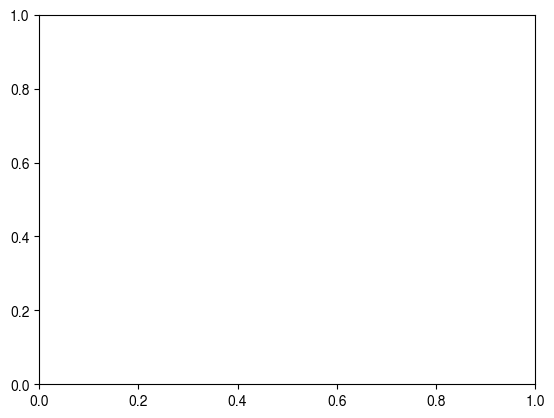

In [226]:
normalise = True
y_axis = "Number of events"
extra_string = basic_extra_string
if normalise: 
    extra_string = basic_extra_string+"_norm"
    y_axis = "Arbitrary Units"


Exclusive_Residual_x = Displacement_x_super_truth_tracks - TrueDisp[:,0]
significance_x = Exclusive_Residual_x/Displacement_x_super_truth_tracks_error

Exclusive_Residual_y = Displacement_y_super_truth_tracks - TrueDisp[:,1]
significance_y = Exclusive_Residual_y/Displacement_y_super_truth_tracks_error

Exclusive_Residual_z = Displacement_z_super_truth_tracks - TrueDisp[:,2]
significance_z = Exclusive_Residual_z/Displacement_z_super_truth_tracks_error

#Inclusive_Residual = inclusive_Displacement_x_super_truth_tracks - LeadHadron_Truth_displacement[:,0]
#Inclusive_Error = inclusive_Displacement_x_super_truth_tracks_error

for flavour in ["bjets", "cjets", "light"]:

    # Choose selection
    if flavour == "all":
        f = ""
        flav_str = "(all flavours)"
    
    if flavour == "bjets":
        f = "b"
        flav_str = "(b-jets)"
    
    if flavour == "cjets":
        f = "c"
        flav_str = "(c-jets)"
    
    if flavour == "light":
        f = "light"
        flav_str = "(light jets)"
    

    selection = jet_flavour(jets, f)
    
    excl_x = Histogram( Exclusive_Residual_x[selection], label="X Residual", histtype="step", alpha=1)    
    excl_y = Histogram( Exclusive_Residual_y[selection], label="Y Residual", histtype="step", alpha=1)    
    excl_z = Histogram( Exclusive_Residual_z[selection], label="Z Residual", histtype="step", alpha=1)    


    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel=y_axis,
        xlabel="Residual (Truth - Predicted) [mm]",
        logy=False,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=15,   # you can also define an integer number for the number of bins
        bins_range=(-3.9,3.9),  # only considered if bins is an integer
        norm=normalise,
        atlas_first_tag="Simulation Internal ",
        atlas_second_tag=mc+" "+sample+" "+flav_str+extra,
        figsize=(6, 5),
        n_ratio_panels=0,
    )

    plot_histo.add(excl_x, reference=True)
    plot_histo.add(excl_y, reference=False)
    plot_histo.add(excl_z, reference=False)

    #plot_histo.add(excl_err_x, reference=False)
    #plot_histo.add(excl_err_y, reference=False)
    #plot_histo.add(excl_err_z, reference=False)

    #plot_histo.add(incl_err, reference=False)
    
    plot_histo.draw()
    
    plot_histo.savefig(output+"/Histogram_Residual_TruthHadronTracks_"+flavour+extra_string+".png", transparent=False)

    
    h_x = Histogram( significance_x[selection], label="X", histtype="step", alpha=1)    
    h_y = Histogram( significance_y[selection], label="Y", histtype="step", alpha=1)    
    h_z = Histogram( significance_z[selection], label="Z", histtype="step", alpha=1)    
    
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel=y_axis,
        xlabel="Vertex Significance Tracks from Truth Hadron",
        logy=False,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=29,   # you can also define an integer number for the number of bins
        bins_range=(-7.25,7.25),  # only considered if bins is an integer
        norm=normalise,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str+extra,
        figsize=(6, 5),
        n_ratio_panels=0,
    )
    
    plot_histo.add(h_x, reference=True)
    plot_histo.add(h_y, reference=False)
    plot_histo.add(h_z, reference=False)
    
    
    plot_histo.draw()
    
    plot_histo.savefig(output+"Histogram_Vertex_Significance_TruthHadronTracks_"+flavour+extra_string+"_norm.png", transparent=False)

In [ ]:
# Get Vertex Index, where are the secondary vertices? 
reco_track_weights, reco_vertex_index = GetTrackWeights(track_data, incl_vertexing=inclusive_vertex, truth=False, max_sv=max_sv) # if not inclusive you can choose to store more than one vertex i.e. max_sv != 1
if inclusive_vertex == False: 
    index_reco_tracks = np.argmax(np.sum(reco_track_weights, axis=2), axis=1)
else:
    index_reco_tracks = 0 

In [ ]:
truth_track_weights, truth_vertex_index = GetTrackWeights(track_data, incl_vertexing=inclusive_vertex, truth=True, max_sv=max_sv) 
if inclusive_vertex == False: 
    index_truth_tracks = np.argmax(np.sum(truth_track_weights, axis=2), axis=1)
else:
    index_truth_tracks = 0 

In [ ]:
if inclusive_vertex == True:
    n_true_tracks = np.array(n_tracks_inclusive_vertex)
else:
    tmp_index = np.where(index_hadron_most_tracks == -99, 0, index_hadron_most_tracks) 
    n_tracks_exclusive_vertex = np.array(n_tracks_exclusive_vertex)
    n_true_tracks = n_tracks_exclusive_vertex[np.arange(len(n_tracks_exclusive_vertex)), tmp_index]

n_reco_sv_tracks = np.sum(reco_track_weights, axis = 2)
n_reco_sv_tracks = np.array(n_reco_sv_tracks[np.arange(n_reco_sv_tracks.shape[0]), index_reco_tracks])

n_truth_sv_tracks = np.sum(truth_track_weights, axis = 2)
n_truth_sv_tracks = np.array(n_truth_sv_tracks[np.arange(n_truth_sv_tracks.shape[0]), index_truth_tracks])


#print(n_true_tracks)
#print(n_reco_sv_tracks)
#print(n_truth_sv_tracks)


normalise = False
y_axis = "Number of events"
extra_string = basic_extra_string
if normalise: 
    extra_string = basic_extra_string+"_norm"
    y_axis = "Arbitrary Units"

for flavour in ["bjets", "cjets", "light"]:

    # Choose selection
    if flavour == "all":
        f = ""
        flav_str = "(all flavours)"
    
    if flavour == "bjets":
        f = "b"
        flav_str = "(b-jets)"
    
    if flavour == "cjets":
        f = "c"
        flav_str = "(c-jets)"
    
    if flavour == "light":
        f = "light"
        flav_str = "(light jets)"
    

    selection = jet_flavour(jets, f)
        
    h_t = Histogram( n_true_tracks[selection], label="Truth Hadron SV", histtype="step", alpha=1)    
    h_sv_t = Histogram( n_truth_sv_tracks[selection], label="Truth SV", histtype="step", alpha=1)    
    h_r = Histogram( n_reco_sv_tracks[selection], label="GN2 SV", histtype="step", alpha=1)    
    
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel=y_axis,
        xlabel="Number of Tracks in Vertex",
        logy=False,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=10,  # you can also define an integer number for the number of bins
        bins_range=(0,10),  # only considered if bins is an integer
        norm=normalise,
        atlas_first_tag="Simulation Internal ",
        atlas_second_tag=mc+" "+sample+" "+flav_str+extra,
        figsize=(6, 5),
        n_ratio_panels=0,
    )

    plot_histo.add(h_t, reference=True)
    plot_histo.add(h_sv_t, reference=False)
    plot_histo.add(h_r, reference=False)
    
    plot_histo.draw()
    
    plot_histo.savefig(output+"Histogram_nTracksVertex_"+flavour+extra_string+".png", transparent=False)




In [197]:
# Compare the track to vertex association at truth level and reco

print("Inclusive Vertex = ", inclusive_vertex)

difference = []
reco_difference = []
reco_to_hadron_difference = []

for i in range(0, truth_track_weights.shape[0]):       

    if inclusive_vertex == False:
        
        j = index_hadron_most_tracks_positive[i] # index for truth hadron which is parent of the highest amount of tracks (ftagparentBarcode associated to truth_hadron barcode)
        # could have used lead_hadron also
        k = index_truth_tracks[i] # index for vertex with highest amount of truth tracks (FTAG function)
        m = index_reco_tracks[i] # index for vertex with highest amount of reco tracks (FTAG function)

        comparison = np.where(truth_track_weights[i, k, :] != exclusive_track_vertex[i, j, :], 1, 0)
        reco_to_hadron_comparison = np.where(exclusive_track_vertex[i, j, :] != reco_track_weights[i, m, :], 1, 0)

    else:            
        j, k, m = 0, 0, 0

        comparison = np.where(truth_track_weights[i, k, :] != inclusive_track_vertex[i], 1, 0)
        reco_to_hadron_comparison = np.where(inclusive_track_vertex[i] != reco_track_weights[i, m, :], 1, 0)

    difference.append(np.sum(comparison))
    reco_to_hadron_difference.append(np.sum(reco_to_hadron_comparison))

    reco_comparison = np.where(truth_track_weights[i, k, :] != reco_track_weights[i, m, :], 1, 0)
    reco_difference.append(np.sum(reco_comparison))


Inclusive Vertex =  False


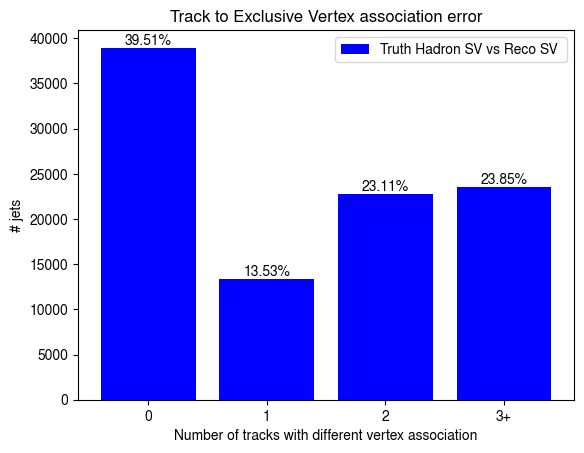

In [198]:
# Make the plots with the track to vertex association comparison for the different functions computed in the previous block
zero = 0
one = 0
two = 0
more = 0

reco_zero = 0
reco_one = 0
reco_two = 0
reco_more = 0

truth_reco_zero = 0
truth_reco_one = 0
truth_reco_two = 0
truth_reco_more = 0


for i in range(0, len(difference)):
    if difference[i] == 0:
        zero += 1
    if difference[i] == 1:
        one += 1
    if difference[i] == 2:
        two += 1
    if difference[i] > 2:
        more += 1

    if reco_difference[i] == 0:
        reco_zero += 1
    if reco_difference[i] == 1:
        reco_one += 1
    if reco_difference[i] == 2:
        reco_two += 1
    if reco_difference[i] > 2:
        reco_more += 1

    if reco_to_hadron_difference[i] == 0:
        truth_reco_zero += 1
    if reco_to_hadron_difference[i] == 1:
        truth_reco_one += 1
    if reco_to_hadron_difference[i] == 2:
        truth_reco_two += 1
    if reco_to_hadron_difference[i] > 2:
        truth_reco_more += 1

# Data
values = [zero, one, two, more] 
reco_values = [reco_zero, reco_one, reco_two, reco_more] 
truth_reco_values = [truth_reco_zero, truth_reco_one, truth_reco_two, truth_reco_more] 

total = sum(values)  # Calculate the total for fractions
fractions = [v / total for v in values]  # Calculate fractions
reco_fractions = [v / total for v in reco_values]  # Calculate fractions
truth_reco_fractions = [v / total for v in truth_reco_values]  # Calculate fractions


labels = ['0', '1', '2', '3+']

# Create a bar chart
bars = plt.bar(labels, values, color='skyblue', label='Truth Hadron SV vs Truth SV ')

# Add legend
plt.legend()

# Add text annotations for each bar
for bar, fraction in zip(bars, fractions):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.5,  # Position text slightly above the bar
        f'{fraction:.2%}',  # Format fraction as a percentage
        ha='center',
        va='bottom'
    )

# Add title and labels
if inclusive_vertex == True: plt.title("Track to Inclusive Vertex association error")
if inclusive_vertex == False: plt.title("Track to Exclusive Vertex association error")
plt.xlabel('Number of tracks with different vertex association')
plt.ylabel('# jets')

# Show plot
plt.savefig(output+"Truth_TrackToVertexError"+basic_extra_string+".png")
plt.clf()

bars = plt.bar(labels, reco_values, color='blue', label='Truth SV vs Reco SV ')

# Add legend
plt.legend()

# Add text annotations for each bar
for bar, fraction in zip(bars, reco_fractions):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.5,  # Position text slightly above the bar
        f'{fraction:.2%}',  # Format fraction as a percentage
        ha='center',
        va='bottom'
    )

# Add title and labels
if inclusive_vertex == True: plt.title("Track to Inclusive Vertex association error")
if inclusive_vertex == False: plt.title("Track to Exclusive Vertex association error")

plt.xlabel('Number of tracks with different vertex association')
plt.ylabel('# jets')

# Show plot
plt.savefig(output+"Reco_TrackToVertexError"+basic_extra_string+".png")


plt.clf()

bars = plt.bar(labels, truth_reco_values, color='blue', label='Truth Hadron SV vs Reco SV ')

# Add legend
plt.legend()

# Add text annotations for each bar
for bar, fraction in zip(bars, truth_reco_fractions):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.5,  # Position text slightly above the bar
        f'{fraction:.2%}',  # Format fraction as a percentage
        ha='center',
        va='bottom'
    )

# Add title and labels
if inclusive_vertex == True: plt.title("Track to Inclusive Vertex association error")
if inclusive_vertex == False: plt.title("Track to Exclusive Vertex association error")

plt.xlabel('Number of tracks with different vertex association')
plt.ylabel('# jets')

# Show plot
plt.savefig(output+"RecoVsTruthHadron_TrackToVertexError"+basic_extra_string+".png")


In [18]:
# Flatten the number of hadrons for exclusive vertex fits
# Do fits with reco tracks 

# Only if you want to fit multiple vertices

# Need to fix this for the exclusive fits

if inclusive_vertex == False: 

    vertex_fit, vertex_covariance_fit, vertex_fit_chi2  = billoir_vertex_fit(jnp.array(x[:]), jnp.array(reco_track_weights[np.arange(reco_track_weights.shape[0]), index_reco_tracks]), jnp.array(seed[:]))
    truth_vertex_fit, truth_vertex_covariance_fit, truth_vertex_fit_chi2  = billoir_vertex_fit(jnp.array(x[:]), jnp.array(truth_track_weights[np.arange(truth_track_weights.shape[0]), index_truth_tracks]), jnp.array(seed[:])) # the y axis for reco_track_weights indicates which vertex is fitted 0 = leading vertex

else:

    vertex_fit, vertex_covariance_fit, vertex_fit_chi2  = billoir_vertex_fit(jnp.array(x[:]), jnp.array(reco_track_weights[:,0,:]), jnp.array(seed[:]))
    truth_vertex_fit, truth_vertex_covariance_fit, truth_vertex_fit_chi2  = billoir_vertex_fit(jnp.array(x[:]), jnp.array(truth_track_weights[:,0,:]), jnp.array(seed[:])) # the y axis for reco_track_weights indicates which vertex is fitted 0 = leading vertex
    

# change dummy values (0 by default) to np.nan
vertex_fit = np.where(vertex_fit == 0, np.nan, vertex_fit)
truth_vertex_fit = np.where(truth_vertex_fit == 0, np.nan, truth_vertex_fit)



In [200]:
# Your super_truth_vertex_fit has some np.nan values.. they should however only be there for jets where no tracks have been associated to hadrons. 
# These jets can be found with the good_hadron_track_association_mask. 
# Let's make sure that both arrays are the same when changing the nan to 0!
tmp = (np.where(good_hadron_track_association_mask == 0, np.nan, super_truth_vertex_fit[:,0]))
NaN = (np.sum(np.isnan(super_truth_vertex_fit[:,0])))
print("Your super_truth_vertex_fit has ", NaN," jets with NaN vertex fit")

if (np.array_equal(tmp, super_truth_vertex_fit[:,0], equal_nan=True)) == True:
    print( " -> [GOOD] This is expected and occurs only for jets that had no tracks associated to any hadrons. ")
    print(len(good_hadron_track_association_mask) -np.sum(good_hadron_track_association_mask), " jets have 0 tracks associated to the hadron with most tracks")
else:
    print( " -> [WARNING]: Some fits have failed despite having tracks associated to hadrons! You may want to look into details!")
    

Your super_truth_vertex_fit has  17633  jets with NaN vertex fit
 -> [GOOD] This is expected and occurs only for jets that had no tracks associated to any hadrons. 
17633  jets have 0 tracks associated to the hadron with most tracks


In [201]:
# Do fits with reco tracks 

# Only if you want to fit multiple vertices

# Need to fix this for the exclusive fits
'''
seed = jnp.zeros((reco_track_weights.shape[0], 3))

for i in range(0, max_sv):
    if i == 0:
        vertex_fit, vertex_covariance_fit, vertex_fit_chi2  = billoir_vertex_fit(jnp.array(x[:]), jnp.array(reco_track_weights[:, i, :]), jnp.array(seed[:]))
        truth_vertex_fit, truth_vertex_covariance_fit, truth_vertex_fit_chi2  = billoir_vertex_fit(jnp.array(x[:]), jnp.array(truth_track_weights[:, 0, :]), jnp.array(seed[:])) # the y axis for reco_track_weights indicates which vertex is fitted 0 = leading vertex
    else:
        tmp_vertex_fit, tmp_vertex_covariance_fit,tmp_vertex_fit_chi2  = billoir_vertex_fit(jnp.array(x[:]), jnp.array(reco_track_weights[:, i, :]), jnp.array(seed[:]))
        tmp_truth_vertex_fit, tmp_truth_vertex_covariance_fit, tmp_truth_vertex_fit_chi2  = billoir_vertex_fit(jnp.array(x[:]), jnp.array(truth_track_weights[:, 0, :]), jnp.array(seed[:])) # the y axis for reco_track_weights indicates which vertex is fitted 0 = leading vertex

        vertex_fit = np.concatenate((vertex_fit, tmp_vertex_fit), axis=0)
        vertex_covariance_fit = np.concatenate((vertex_covariance_fit, tmp_vertex_covariance_fit), axis=0)
        vertex_fit_chi2 = np.concatenate((vertex_fit_chi2, tmp_vertex_fit_chi2), axis=0)    

        truth_vertex_fit = np.concatenate((truth_vertex_fit, tmp_truth_vertex_fit), axis=0)
        truth_vertex_covariance_fit = np.concatenate((truth_vertex_covariance_fit, tmp_truth_vertex_covariance_fit), axis=0)
        truth_vertex_fit_chi2 = np.concatenate((truth_vertex_fit_chi2, tmp_truth_vertex_fit_chi2), axis=0)    


# change dummy values (0 by default) to np.nan
vertex_fit = np.where(vertex_fit == 0, np.nan, vertex_fit)
truth_vertex_fit = np.where(truth_vertex_fit == 0, np.nan, truth_vertex_fit)

if max_sv == 1: Truth_displacement = truth_hadron_displacement[:, 0, : ]
if max_sv == 2: Truth_displacement = np.concatenate((truth_hadron_displacement[:, 0, :], truth_hadron_displacement[:, 1, :]), axis = 0)
if max_sv == 3: Truth_displacement = np.concatenate((truth_hadron_displacement[:, 0, :], truth_hadron_displacement[:, 1, :], truth_hadron_displacement[:, 2, :]), axis = 0)

PVtoBeam_X = my_data["jets"]['PVtoBeam_displacement_X']
PVtoBeam_Y = my_data["jets"]['PVtoBeam_displacement_Y']
PVtoBeam_Z = my_data["jets"]['PVtoBeam_displacement_Z']

PVtoBeam_X = np.repeat(PVtoBeam_X, max_sv, axis=0)
PVtoBeam_Y = np.repeat(PVtoBeam_Y, max_sv, axis=0)
PVtoBeam_Z = np.repeat(PVtoBeam_Z, max_sv, axis=0)

'''

'\nseed = jnp.zeros((reco_track_weights.shape[0], 3))\n\nfor i in range(0, max_sv):\n    if i == 0:\n        vertex_fit, vertex_covariance_fit, vertex_fit_chi2  = billoir_vertex_fit(jnp.array(x[:]), jnp.array(reco_track_weights[:, i, :]), jnp.array(seed[:]))\n        truth_vertex_fit, truth_vertex_covariance_fit, truth_vertex_fit_chi2  = billoir_vertex_fit(jnp.array(x[:]), jnp.array(truth_track_weights[:, 0, :]), jnp.array(seed[:])) # the y axis for reco_track_weights indicates which vertex is fitted 0 = leading vertex\n    else:\n        tmp_vertex_fit, tmp_vertex_covariance_fit,tmp_vertex_fit_chi2  = billoir_vertex_fit(jnp.array(x[:]), jnp.array(reco_track_weights[:, i, :]), jnp.array(seed[:]))\n        tmp_truth_vertex_fit, tmp_truth_vertex_covariance_fit, tmp_truth_vertex_fit_chi2  = billoir_vertex_fit(jnp.array(x[:]), jnp.array(truth_track_weights[:, 0, :]), jnp.array(seed[:])) # the y axis for reco_track_weights indicates which vertex is fitted 0 = leading vertex\n\n        verte

In [21]:

Displacement_x = np.array(vertex_fit[:, 0] + PVtoBeam_X) # the - will have to be a + when we use a newer sample vesion bc Dan changed the definition
Displacement_y = np.array(vertex_fit[:, 1] + PVtoBeam_Y)
Displacement_z = np.array(vertex_fit[:, 2] + PVtoBeam_Z)

Lxy = np.sqrt( Displacement_x**2 + Displacement_y**2)
Lxyz = np.sqrt( Displacement_x**2 + Displacement_y**2 + Displacement_z**2)

# This is not the error on the displacement but the error on the X, Y, Z position of the SV
Displacement_x_error = np.sqrt(vertex_covariance_fit[:, 0, 0])
Displacementx_y_error = np.sqrt(vertex_covariance_fit[:, 1, 1])
Displacement_z_error = np.sqrt(vertex_covariance_fit[:, 2, 2])


#error_x = np.array(Truth_Displacement_x - Displacement_x)
#error_y = np.array(Truth_Displacement_y - Displacement_y)
#error_z = np.array(Truth_Displacement_z - Displacement_z)

#significance_x = error_x/Displacement_x_error 
#significance_y = error_y/Displacementx_y_error
#significance_z = error_z/Displacement_z_error


# What if we use truth tracks instead?

Displacement_x_truth_tracks = np.array(truth_vertex_fit[:, 0] + PVtoBeam_X) # the - will have to be a + when we use a newer sample vesion bc Dan changed the definition
Displacement_y_truth_tracks = np.array(truth_vertex_fit[:, 1] + PVtoBeam_Y) 
Displacement_z_truth_tracks = np.array(truth_vertex_fit[:, 2] + PVtoBeam_Z) 

Lxy_truth_tracks = np.sqrt( Displacement_x_truth_tracks**2 + Displacement_y_truth_tracks**2)
Lxyz_truth_tracks = np.sqrt( Displacement_x_truth_tracks**2 + Displacement_y_truth_tracks**2 + Displacement_z_truth_tracks**2)



/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid v

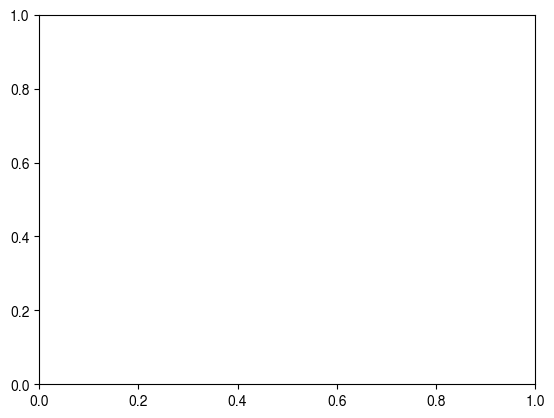

In [185]:
for flavour in ["bjets", "cjets", "light"]:

    # Choose selection
    if flavour == "all":
        f = ""
        flav_str = "(all flavours)"
    
    if flavour == "bjets":
        f = "b"
        flav_str = "(b-jets)"
    
    if flavour == "cjets":
        f = "c"
        flav_str = "(c-jets)"
    
    if flavour == "light":
        f = "light"
        flav_str = "(light jets)"
    

    truth_hist = Histogram(Truth_Lxyz[jet_flavour(jets, f)], label="Truth", histtype="step", alpha=1)
    sv1_hist = Histogram(jets["SV1_L3d"][jet_flavour(jets, f)], label="SV1", histtype="step", alpha=1)
    JetFitter_hist = Histogram(jets["JetFitterSecondaryVertex_displacement3d"][jet_flavour(jets, f)], label="JetFitter", histtype="step", alpha=1)
        
        
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel="Number of events",
        xlabel="Lxyz [mm]",
        logy=True,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=40,  # you can also define an integer number for the number of bins
        bins_range=(0,80),  # only considered if bins is an integer
        norm=False,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str,
        figsize=(6, 5),
        n_ratio_panels=1,
    )
    
    plot_histo.add(truth_hist, reference=True)
    plot_histo.add(sv1_hist, reference=False)
    plot_histo.add(JetFitter_hist, reference=False)
    
    
    plot_histo.draw()
    
    plot_histo.savefig(output+"Histogram_Lxyz_Truth_vs_SV1_JetFitter_"+flavour+".png", transparent=False)
    
    truth_hist_v0 = Histogram(jets["HadronConeExclTruthLabelLxy"][jet_flavour(jets, f) ], label="HadronConeExclTruthLabelLxy", histtype="step", alpha=1)
    truth_hist = Histogram(Truth_Lxy[jet_flavour(jets, f) ], label="Truth", histtype="step", alpha=1)
    sv1_hist = Histogram(jets["SV1_Lxy"][jet_flavour(jets, f) ], label="SV1", histtype="step", alpha=1)
    JetFitter_hist = Histogram(jets["JetFitterSecondaryVertex_displacement2d"][jet_flavour(jets, f)], label="JetFitter", histtype="step", alpha=1)
        
        
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel="Number of events",
        xlabel="Lxy [mm]",
        logy=True,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=40,  # you can also define an integer number for the number of bins
        bins_range=(0,40),  # only considered if bins is an integer
        norm=False,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str,
        figsize=(6, 5),
        n_ratio_panels=1,
    )
    
    
    plot_histo.add(truth_hist, reference=True)
    plot_histo.add(sv1_hist, reference=False)
    plot_histo.add(JetFitter_hist, reference=False)
    plot_histo.add(truth_hist_v0, reference=False)


    plot_histo.draw()

    plot_histo.savefig(output+"Histogram_Lxy_Truth_vs_SV1_JetFitter_"+flavour+".png", transparent=False)


/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid v

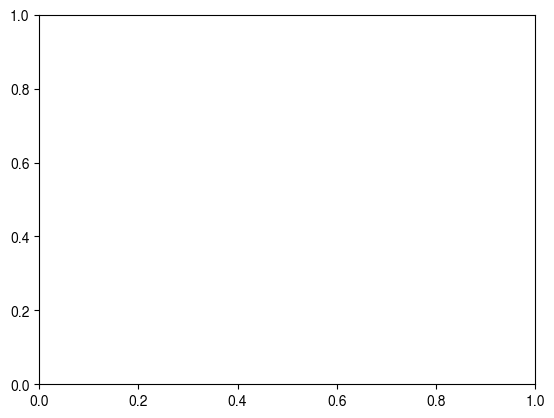

In [154]:
normalise = False
y_axis = "Number of events"
extra_string = basic_extra_string
if normalise: 
    extra_string = basic_extra_string+"_norm"
    y_axis = "Arbitrary Units"

for flavour in ["bjets", "cjets", "light"]:

    # Choose selection
    if flavour == "all":
        f = ""
        flav_str = "(all flavours)"
    
    if flavour == "bjets":
        f = "b"
        flav_str = "(b-jets)"
    
    if flavour == "cjets":
        f = "c"
        flav_str = "(c-jets)"
    
    if flavour == "light":
        f = "light"
        flav_str = "(light jets)"
    

    selection = jet_flavour(jets, f)
        
    h_r = Histogram( Displacement_x[selection], label="Vertex Fit (GN2 SV)", histtype="step", alpha=1)    
    h_t = Histogram( Displacement_x_truth_tracks[selection], label="Vertex Fit (Truth SV)", histtype="step", alpha=1)    
    truth = Histogram( Truth_Displacement_x[selection], label="Truth", histtype="step", alpha=1)    
    h_st = Histogram( Displacement_x_super_truth_tracks[selection], label = "Vertex Fit (Hadron Truth SV)",  histtype="step", alpha=1)    
    
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel=y_axis,
        xlabel="SV Displacement X",
        logy=False,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=19,  # you can also define an integer number for the number of bins
        bins_range=(-9.5,9.5),  # only considered if bins is an integer
        norm=normalise,
        atlas_first_tag="Simulation Internal ",
        atlas_second_tag=mc+" "+sample+" "+flav_str+extra,
        figsize=(6, 5),
        n_ratio_panels=1,
    )

    plot_histo.add(truth, reference=True)
    plot_histo.add(h_r, reference=False)
    plot_histo.add(h_t, reference=False)
    plot_histo.add(h_st, reference=False)
    
    plot_histo.draw()
    
    plot_histo.savefig(output+"Histogram_Vertex_X_"+flavour+extra_string+".png", transparent=False)


    h_r = Histogram( Displacement_y[selection], label="Vertex Fit (GN2 SV)", histtype="step", alpha=1)    
    h_t = Histogram( Displacement_y_truth_tracks[selection], label="Vertex Fit (Truth SV)", histtype="step", alpha=1)    
    truth = Histogram( Truth_Displacement_y[selection], label="Truth", histtype="step", alpha=1)    
    h_st = Histogram( Displacement_y_super_truth_tracks[selection], label = "Vertex Fit (Hadron Truth SV)",  histtype="step", alpha=1)    

    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel=y_axis,
        xlabel="SV Displacement Y",
        logy=False,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=19,  # you can also define an integer number for the number of bins
        bins_range=(-9.5,9.5),  # only considered if bins is an integer
        norm=normalise,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str+extra,
        figsize=(6, 5),
        n_ratio_panels=1,
    )

    plot_histo.add(truth, reference=True)
    plot_histo.add(h_r, reference=False)
    plot_histo.add(h_t, reference=False)
    plot_histo.add(h_st, reference=False)

        
    plot_histo.draw()
    
    plot_histo.savefig(output+"Histogram_Vertex_Y_"+flavour+extra_string+".png", transparent=False)


    
    h_r = Histogram( Displacement_z[selection], label="Vertex Fit (GN2 SV)", histtype="step", alpha=1)    
    h_t = Histogram( Displacement_z_truth_tracks[selection], label="Vertex Fit (Truth SV)", histtype="step", alpha=1)    
    truth = Histogram( Truth_Displacement_z[selection], label="Truth", histtype="step", alpha=1)    
    h  = Histogram( np.array(truth_vertex_fit[:, 2])[selection], label="Vertex Fit (truth - check)", histtype="step", alpha=1)    
    h_st = Histogram( Displacement_z_super_truth_tracks[selection], label = "Vertex Fit (Hadron Truth SV)",  histtype="step", alpha=1)    
        
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel=y_axis,
        xlabel="SV Displacement Z",
        logy=False,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=19,  # you can also define an integer number for the number of bins
        bins_range=(-9.5,9.5),  # only considered if bins is an integer
        norm=normalise,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str+extra,
        figsize=(6, 5),
        n_ratio_panels=1,
    )
    
    plot_histo.add(truth, reference=True)
    plot_histo.add(h_r, reference=False)
    plot_histo.add(h_t, reference=False)
    plot_histo.add(h_st, reference=False)

    
    
    plot_histo.draw()
    
    plot_histo.savefig(output+"Histogram_Vertex_Z_"+flavour+extra_string+".png", transparent=False)

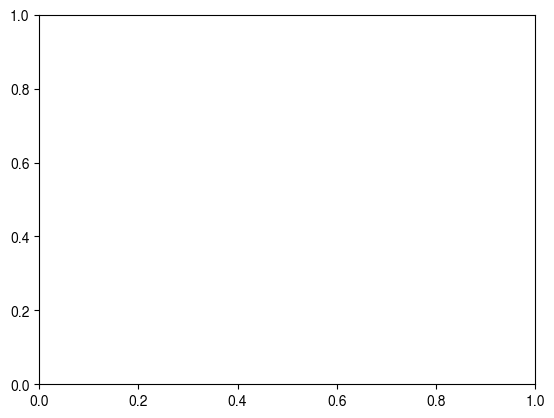

In [245]:
normalise = True
y_axis = "Number of events"
extra_string = basic_extra_string
if normalise: 
    extra_string = basic_extra_string+"_norm"
    y_axis = "Arbitrary Units"


for flavour in ["bjets", "cjets", "light"]:

    # Choose selection
    if flavour == "all":
        f = ""
        flav_str = "(all flavours)"
    
    if flavour == "bjets":
        f = "b"
        flav_str = "(b-jets)"
    
    if flavour == "cjets":
        f = "c"
        flav_str = "(c-jets)"
    
    if flavour == "light":
        f = "light"
        flav_str = "(light jets)"
    
    selection = jet_flavour(jets, f)

    #expectation_hist = Histogram(vertex_metrics["n_match"][is_flavour], label="n match", histtype="stepfilled", alpha=1)
    
    # the variable needs to be an array
    
    h_x = Histogram( error_x[selection], label="Residual X", histtype="step", alpha=1)    
    h_y = Histogram( error_y[selection], label="Residual Y", histtype="step", alpha=1)    
    h_z = Histogram( error_z[selection], label="Residual Z", histtype="step", alpha=1)    
    
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel=y_axis,
        xlabel="Residual (Truth - Predicted) [mm]",
        logy=False,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=15,   # you can also define an integer number for the number of bins
        bins_range=(-3.9,3.9),  # only considered if bins is an integer
        norm=normalise,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str+extra,
        figsize=(6, 5),
        n_ratio_panels=0,
    )
    
    plot_histo.add(h_x, reference=True)
    plot_histo.add(h_y, reference=False)
    plot_histo.add(h_z, reference=False)
    
    
    plot_histo.draw()
    
    plot_histo.savefig(output+"Histogram_Vertex_Error_"+flavour+extra_string+".png", transparent=False)

    
    h_x = Histogram( significance_x[selection], label="X", histtype="step", alpha=1)    
    h_y = Histogram( significance_y[selection], label="Y", histtype="step", alpha=1)    
    h_z = Histogram( significance_z[selection], label="Z", histtype="step", alpha=1)    
    
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel=y_axis,
        xlabel="GN2 Vertex Significance",
        logy=False,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=29,   # you can also define an integer number for the number of bins
        bins_range=(-7.25,7.25),  # only considered if bins is an integer
        norm=normalise,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str+extra,
        figsize=(6, 5),
        n_ratio_panels=0,
    )
    
    plot_histo.add(h_x, reference=True)
    plot_histo.add(h_y, reference=False)
    plot_histo.add(h_z, reference=False)
    
    
    plot_histo.draw()
    
    plot_histo.savefig(output+"Histogram_Vertex_Significance_"+flavour+extra_string+"_norm.png", transparent=False)

/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/fs/ddn/sdf/group/atlas/d/lapereir/miniconda3/envs/puma/lib/python3.8/site-packages/puma/histogram.py:761: RuntimeWarning: invalid v

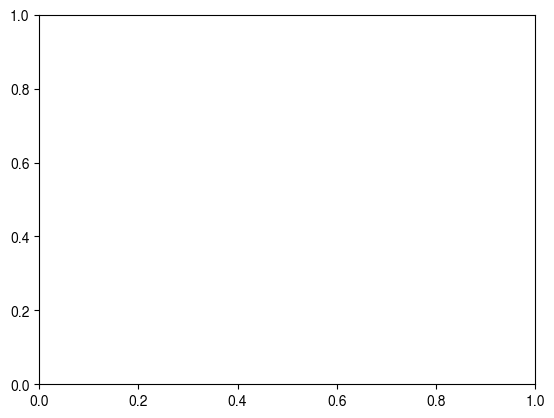

In [233]:
normalise = False
extra_string = basic_extra_string
y_axis = "Number of events"
if normalise: 
    extra_string = basic_extra_string+"_norm"
    y_axis = "Arbitrary Units"


for flavour in ["bjets", "cjets", "light"]:

    # Choose selection
    if flavour == "all":
        f = ""
        flav_str = "(all flavours)"
    
    if flavour == "bjets":
        f = "b"
        flav_str = "(b-jets)"
    
    if flavour == "cjets":
        f = "c"
        flav_str = "(c-jets)"
    
    if flavour == "light":
        f = "light"
        flav_str = "(light jets)"
    

    truth_hist = Histogram(Truth_Lxyz[jet_flavour(jets, f)], label="Truth", histtype="step", alpha=1)
    gn2_hist =  Histogram(Lxyz[jet_flavour(jets, f) ], label="Vertex Fit (GN2 SV)", histtype="step", alpha=1)
    gn2_perfect_hist =  Histogram(Lxyz_truth_tracks[jet_flavour(jets, f) ], label="Vertex Fit (Truth SV)", histtype="step", alpha=1)
    gn2_super_perfect_hist =  Histogram(Lxyz_super_truth_tracks[jet_flavour(jets, f) ], label="Vertex Fit (Hadron Truth SV)", histtype="step", alpha=1)
    sv1_hist = Histogram(jets["SV1_L3d"][jet_flavour(jets, f)], label="SV1", histtype="step", alpha=1)
    JetFitter_hist = Histogram(jets["JetFitterSecondaryVertex_displacement3d"][jet_flavour(jets, f)], label="JetFitter", histtype="step", alpha=1)
        
        
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel=y_axis,
        xlabel="Lxyz [mm]",
        logy=True,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=40,  # you can also define an integer number for the number of bins
        bins_range=(0,80),  # only considered if bins is an integer
        norm=normalise,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str+extra,
        figsize=(6, 5),
        n_ratio_panels=1,
    )
    
    plot_histo.add(gn2_hist, reference=False)
    plot_histo.add(gn2_perfect_hist, reference=False)
    plot_histo.add(gn2_super_perfect_hist, reference=False)
    plot_histo.add(sv1_hist, reference=False)
    plot_histo.add(JetFitter_hist, reference=False)
    plot_histo.add(truth_hist, reference=True)
    
    
    plot_histo.draw()
    
    plot_histo.savefig(output+"Histogram_Lxyz_"+flavour+extra_string+".png", transparent=False)
    
    truth_hist_v0 = Histogram(jets["HadronConeExclTruthLabelLxy"][jet_flavour(jets, f)], label="Truth HadronConeExclTruthLabelLxy", histtype="step", alpha=1)
    truth_hist = Histogram(Truth_Lxy[jet_flavour(jets, f)], label="Truth", histtype="step", alpha=1)
    gn2_hist =  Histogram(Lxy[jet_flavour(jets, f)], label="Vertex Fit (GN2 SV)", histtype="step", alpha=1)
    gn2_perfect_hist =  Histogram(Lxy_truth_tracks[jet_flavour(jets, f)], label="Vertex Fit (Truth SV)", histtype="step", alpha=1)
    gn2_super_perfect_hist =  Histogram(Lxy_super_truth_tracks[jet_flavour(jets, f)], label="Vertex Fit (Hadron Truth SV)", histtype="step", alpha=1)
    sv1_hist = Histogram(jets["SV1_Lxy"][jet_flavour(jets, f) ], label="SV1", histtype="step", alpha=1)
    JetFitter_hist = Histogram(jets["JetFitterSecondaryVertex_displacement2d"][jet_flavour(jets, f)], label="JetFitter", histtype="step", alpha=1)
        
        
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel=y_axis,
        xlabel="Lxy [mm]",
        logy=True,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=40,  # you can also define an integer number for the number of bins
        bins_range=(0,40),  # only considered if bins is an integer
        norm=normalise,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str+extra,
        figsize=(6, 5),
        n_ratio_panels=1,
    )
    
    
    plot_histo.add(gn2_hist, reference=False)
    plot_histo.add(gn2_perfect_hist, reference=False)
    plot_histo.add(gn2_super_perfect_hist, reference=False)
    plot_histo.add(sv1_hist, reference=False)
    plot_histo.add(JetFitter_hist, reference=False)
    plot_histo.add(truth_hist, reference=True)


    plot_histo.draw()

    plot_histo.savefig(output+"Histogram_Lxy_"+flavour+extra_string+".png", transparent=False)




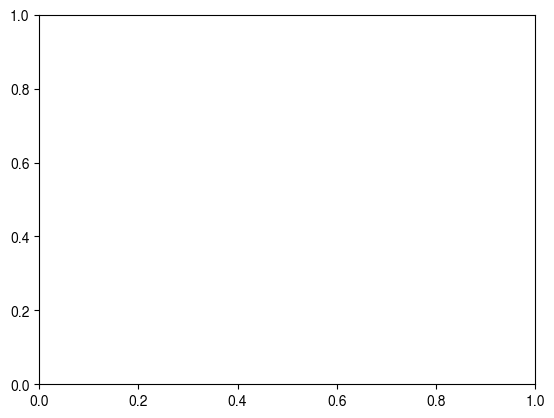

In [238]:
normalise = False
extra_string = basic_extra_string
y_axis = "Number of events"
if normalise: 
    extra_string = basic_extra_string+"_norm"
    y_axis = "Arbitrary Units"

Lxy_error_GN2_tracks = (Truth_Lxy - Lxy)
Lxy_error_truth_tracks = (Truth_Lxy - Lxy_truth_tracks)
Lxy_error_super_truth_tracks = (Truth_Lxy - Lxy_super_truth_tracks)

SV1_Lxy_error = (Truth_Lxy - jets["SV1_Lxy"])
JetFitter_Lxy_error = (Truth_Lxy - jets["JetFitterSecondaryVertex_displacement2d"])


Lxyz_error_GN2_tracks = (Truth_Lxyz - Lxyz)
Lxyz_error_truth_tracks = (Truth_Lxyz - Lxyz_truth_tracks)

SV1_Lxyz_error = (Truth_Lxyz - jets["SV1_L3d"])
JetFitter_Lxyz_error = (Truth_Lxyz - jets["JetFitterSecondaryVertex_displacement3d"])

for flavour in ["bjets", "cjets", "light"]:

    # Choose selection
    if flavour == "all":
        f = ""
        flav_str = "(all flavours)"
    
    if flavour == "bjets":
        f = "b"
        flav_str = "(b-jets)"
    
    if flavour == "cjets":
        f = "c"
        flav_str = "(c-jets)"
    
    if flavour == "light":
        f = "light"
        flav_str = "(light jets)"
    
    
    #expectation_hist = Histogram(vertex_metrics["n_match"][is_flavour], label="n match", histtype="stepfilled", alpha=1)
    
    # the variable needs to be an array

    gn2_hist =  Histogram(Lxy_error_GN2_tracks[jet_flavour(jets, f) ], label="Vertex Fit (GN2 SV)", histtype="step", alpha=1)  
    gn2_hist_truth =  Histogram(Lxy_error_truth_tracks[jet_flavour(jets, f) ], label="Vertex Fit (Truth SV)", histtype="step", alpha=1)  
    gn2_hist_super_truth =  Histogram(Lxy_error_super_truth_tracks[jet_flavour(jets, f) ], label="Vertex Fit (Truth Hadron SV)", histtype="step", alpha=1)      
    sv1_hist =  Histogram(SV1_Lxy_error[jet_flavour(jets, f) ], label="SV1", histtype="step", alpha=1)  
    jf_hist =  Histogram(JetFitter_Lxy_error[jet_flavour(jets, f) ], label="JetFitter", histtype="step", alpha=1)  
        
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel=y_axis,
        xlabel="Lxy Residual [mm]",
        logy=False,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=19,  # you can also define an integer number for the number of bins
        bins_range=(-9.5,9.5),  # only considered if bins is an integer
        norm=normalise,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str+extra,
        figsize=(6, 5),
        n_ratio_panels=0,
    )
    
    plot_histo.add(gn2_hist, reference=False)
    plot_histo.add(gn2_hist_truth, reference=False)
    plot_histo.add(gn2_hist_super_truth, reference=True)
    plot_histo.add(sv1_hist, reference=False)
    plot_histo.add(jf_hist, reference=False)
    
    
    plot_histo.draw()
    plot_histo.savefig(output+"Histogram_Lxy_Residual_"+flavour+extra_string+".png", transparent=False)


    gn2_hist =  Histogram(Lxyz_error_GN2_tracks[jet_flavour(jets, f) ], label="Vertex Fit (GN2 SV)", histtype="step", alpha=1)  
    gn2_hist_truth =  Histogram(Lxyz_error_truth_tracks[jet_flavour(jets, f) ], label="Vertex Fit (Truth SV)", histtype="step", alpha=1)  
    gn2_hist_super_truth =  Histogram(Lxy_error_super_truth_tracks[jet_flavour(jets, f) ], label="Vertex Fit (Truth Hadron SV)", histtype="step", alpha=1)      
    sv1_hist =  Histogram(SV1_Lxyz_error[jet_flavour(jets, f) ], label="SV1", histtype="step", alpha=1)  
    jf_hist =  Histogram(JetFitter_Lxyz_error[jet_flavour(jets, f) ], label="JetFitter", histtype="step", alpha=1)  
        
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel=y_axis,
        xlabel="Lxyz Residual [mm]",
        logy=False,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=19,  # you can also define an integer number for the number of bins
        bins_range=(-9.5,9.5),  # only considered if bins is an integer
        norm=normalise,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str+extra,
        figsize=(6, 5),
        n_ratio_panels=0,
    )
    
    plot_histo.add(gn2_hist, reference=False)
    plot_histo.add(gn2_hist_truth, reference=False)
    plot_histo.add(gn2_hist_super_truth, reference=True)
    plot_histo.add(sv1_hist, reference=False)
    plot_histo.add(jf_hist, reference=False)
    
    
    plot_histo.draw()
    plot_histo.savefig(output+"Histogram_Lxyz_Residual_"+flavour+extra_string+".png", transparent=False)



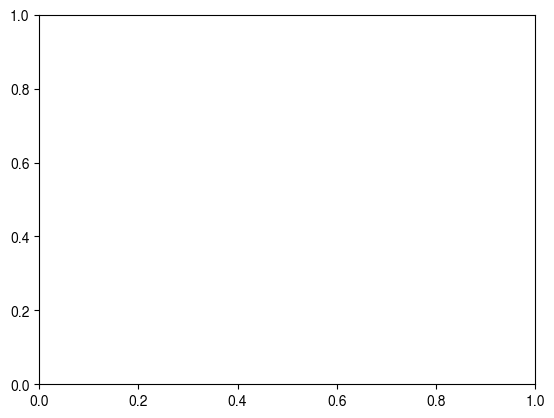

In [235]:
# Residual with pre-existing Truth Lxy variable


normalise = False
extra_string = basic_extra_string
my_extra = " HadronConeExclTruthLabelLxy "
y_axis = "Number of events"
if normalise: 
    extra_string = basic_extra_string+"_norm"
    y_axis = "Arbitrary Units"

Lxy_error_GN2_tracks = (jets["HadronConeExclTruthLabelLxy"] - Lxy)
Lxy_error_truth_tracks = (jets["HadronConeExclTruthLabelLxy"] - Lxy_truth_tracks)
Lxy_error_super_truth_tracks = (jets["HadronConeExclTruthLabelLxy"] - Lxy_super_truth_tracks)

SV1_Lxy_error = (jets["HadronConeExclTruthLabelLxy"] - jets["SV1_Lxy"])
JetFitter_Lxy_error = (jets["HadronConeExclTruthLabelLxy"] - jets["JetFitterSecondaryVertex_displacement2d"])

for flavour in ["bjets", "cjets", "light"]:

    # Choose selection
    if flavour == "all":
        f = ""
        flav_str = "(all flavours)"
    
    if flavour == "bjets":
        f = "b"
        flav_str = "(b-jets)"
    
    if flavour == "cjets":
        f = "c"
        flav_str = "(c-jets)"
    
    if flavour == "light":
        f = "light"
        flav_str = "(light jets)"
    
    
    #expectation_hist = Histogram(vertex_metrics["n_match"][is_flavour], label="n match", histtype="stepfilled", alpha=1)
    
    # the variable needs to be an array

    gn2_hist =  Histogram(Lxy_error_GN2_tracks[jet_flavour(jets, f) ], label="Vertex Fit (GN2 SV)", histtype="step", alpha=1)  
    gn2_hist_truth =  Histogram(Lxy_error_truth_tracks[jet_flavour(jets, f) ], label="Vertex Fit (Truth SV)", histtype="step", alpha=1)  
    gn2_hist_super_truth =  Histogram(Lxy_error_super_truth_tracks[jet_flavour(jets, f) ], label="Vertex Fit (Truth Hadron SV)", histtype="step", alpha=1)      
    sv1_hist =  Histogram(SV1_Lxy_error[jet_flavour(jets, f) ], label="SV1", histtype="step", alpha=1)  
    jf_hist =  Histogram(JetFitter_Lxy_error[jet_flavour(jets, f) ], label="JetFitter", histtype="step", alpha=1)  
        
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel=y_axis,
        xlabel="Lxy Residual [mm]",
        logy=False,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=19,  # you can also define an integer number for the number of bins
        bins_range=(-9.5,9.5),  # only considered if bins is an integer
        norm=normalise,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str+my_extra,
        figsize=(6, 5),
        n_ratio_panels=0,
    )
    
    plot_histo.add(gn2_hist, reference=False)
    plot_histo.add(gn2_hist_truth, reference=False)
    plot_histo.add(gn2_hist_super_truth, reference=True)
    plot_histo.add(sv1_hist, reference=False)
    plot_histo.add(jf_hist, reference=False)
    
    
    plot_histo.draw()
    plot_histo.savefig(output+"Histogram_Lxy_Residual_Truth_Hadron_Variable_"+flavour+extra_string+".png", transparent=False)


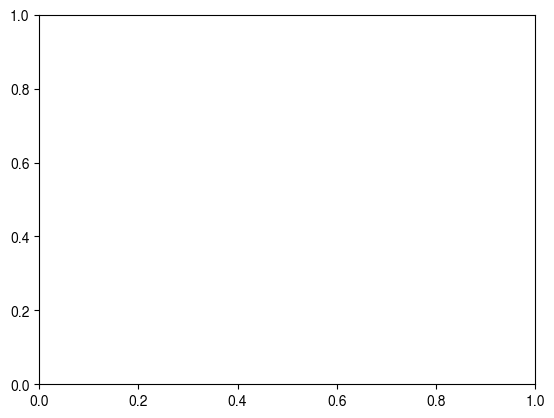

In [158]:


GN2_Lxyz_error = (Truth_Lxyz - Lxyz)
GN2_Lxyz_error_truth = (Truth_Lxyz - Lxyz_truth_tracks)

#GN2_buggy_Lxy_error = (truth_vertex_Lxy - buggy_Lxy)

SV1_Lxyz_error = (Truth_Lxyz - jets["SV1_L3d"])
JetFitter_Lxyz_error = (Truth_Lxyz - jets["JetFitterSecondaryVertex_displacement3d"])


for flavour in ["bjets", "cjets"]:

    # Choose selection
    if flavour == "all":
        f = ""
        flav_str = "(all flavours)"
    
    if flavour == "bjets":
        f = "b"
        flav_str = "(b-jets)"
    
    if flavour == "cjets":
        f = "c"
        flav_str = "(c-jets)"
    
    if flavour == "light":
        f = "light"
        flav_str = "(light jets)"
    
    
    #expectation_hist = Histogram(vertex_metrics["n_match"][is_flavour], label="n match", histtype="stepfilled", alpha=1)
    
    # the variable needs to be an array

    gn2_hist =  Histogram(GN2_Lxyz_error[jet_flavour(jets, f)], label="Billoir Vertex Fit (GN2 SV)", histtype="step", alpha=1)  
    gn2_hist_truth =  Histogram(GN2_Lxyz_error_truth[jet_flavour(jets, f)], label="Billoir Vertex Fit (Truth SV)", histtype="step", alpha=1)  

    sv1_hist =  Histogram(SV1_Lxyz_error[jet_flavour(jets, f) ], label="SV1", histtype="step", alpha=1)  
    jf_hist =  Histogram(JetFitter_Lxyz_error[jet_flavour(jets, f)], label="JetFitter", histtype="step", alpha=1)  
        
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel="Number of events",
        xlabel="(Truth - Reco) Lxyz [mm]",
        logy=True,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=19,  # you can also define an integer number for the number of bins
        bins_range=(-9.5,9.5),  # only considered if bins is an integer
        norm=False,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str+extra,
        figsize=(6, 5),
        n_ratio_panels=0,
    )
    
    plot_histo.add(gn2_hist, reference=False)
    plot_histo.add(gn2_hist_truth, reference=True)
    plot_histo.add(sv1_hist, reference=False)
    plot_histo.add(jf_hist, reference=False)
    
    
    plot_histo.draw()
    
    plot_histo.savefig(output+"Histogram_Lxyz_Error_"+flavour+extra_string+".png", transparent=False)


In [106]:
# Other metrics from Johanne's
#     Dictionary containing the following metrics:
#         n_match: np.ndarray
#             Array of shape (n_jets) containing the number of matched vertices per
#             jet.
#         n_test: np.ndarray
#             Array of shape (n_jets) containing the number of reco vetices per jet.
#         n_ref: np.ndarray
#             Array of shape (n_jets) containing the number of truth vertices per jet.
#         track_overlap: np.ndarray
#             Array of shape (n_jets, max_vertices) containing the number of
#             overlapping tracks between each matched vertex pair.
#         test_vertex_size: np.ndarray
#             Array of shape (n_jets, max_vertices) containing the number of tracks
#             in each matched reco vertex.
#         ref_vertex_size: np.ndarray
#             Array of shape (n_jets, max_vertices) containing the number of tracks
#             in each matched truth vertex.


vertex_metrics = calculate_vertex_metrics(reco_vertex_index, truth_vertex_index)

n_reco_vertex = vertex_metrics["n_test"] # 1D (jet)
n_truth_vertex = vertex_metrics["n_ref"] # 1D (jet)

n_reco_tracks_per_vertex = vertex_metrics["test_vertex_size"] # 2D (jet, vertex)
n_truth_tracks_per_vertex = vertex_metrics["ref_vertex_size"]  # 2D (jet, vertex)

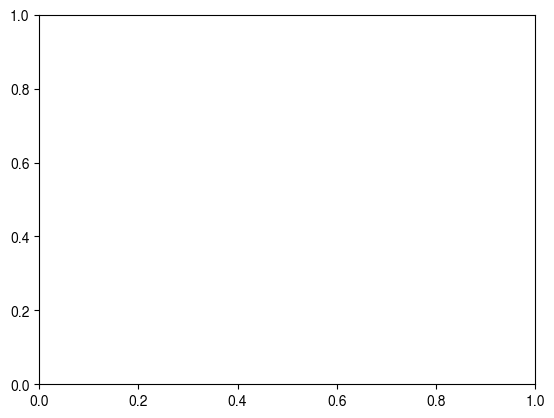

In [108]:
var = n_reco_vertex
var_name = "num_SV_reco"

    
#expectation_hist = Histogram(vertex_metrics["n_match"][is_flavour], label="n match", histtype="stepfilled", alpha=1)

# the variable needs to be an array

b_hist = Histogram(var[jet_flavour(jets, "b")], label="b-jets", histtype="step", alpha=1)
c_hist = Histogram(var[jet_flavour(jets, "c")], label="c-jets", histtype="step", alpha=1)
l_hist = Histogram(var[jet_flavour(jets, "light")], label="light-flavour jets", histtype="step", alpha=1)
#sv1_hist = Histogram(jets["SV1_Lxy"][jet_flavour(jets, f)], label="SV1", histtype="step", alpha=1)
#JetFitter_hist = Histogram(jets["JetFitterSecondaryVertex_displacement2d"][jet_flavour(jets, f)], label="JetFitter", histtype="step", alpha=1)


# Initialise histogram plot
plot_histo = HistogramPlot(
    ylabel="Arbitrary Units",
    xlabel="GN2 (non-inclusive) # SV",
    logy=False,
    # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
    bins=6,  # you can also define an integer number for the number of bins
    bins_range=(0,6),  # only considered if bins is an integer
    norm=True,
    atlas_first_tag="Simulation Internal",
    atlas_second_tag=mc+" "+sample+ ", " + cut_str,
    figsize=(6, 3),
    n_ratio_panels=0,
)

#plot_histo.add(truth_hist, reference=True)
plot_histo.add(b_hist, reference=True)
plot_histo.add(c_hist, reference=False)
plot_histo.add(l_hist, reference=False)

#plot_histo.add(sv1_hist, reference=False)
#plot_histo.add(JetFitter_hist, reference=False)


plot_histo.draw()

plot_histo.savefig(output+"Histogram_"+var_name+"_norm.png", transparent=False)

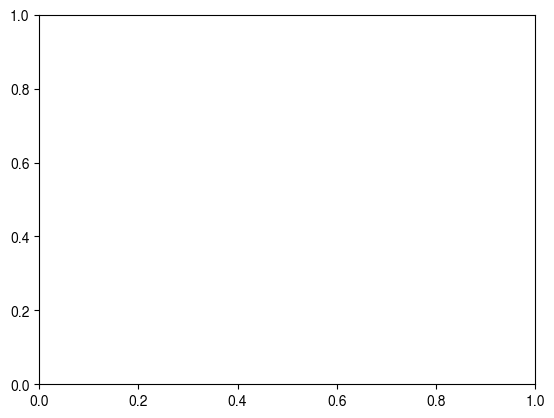

In [126]:
# Number of vertices 

n_true_hadrons = np.where(np.isnan(hadron_indices[good_jets]), 0, 1)
n_true_hadrons = np.sum(n_true_hadrons, axis = 1)

normalise = False
y_axis = "Number of events"
extra_string = basic_extra_string
if normalise: 
    extra_string = basic_extra_string+"_norm"
    y_axis = "Arbitrary Units"

for flavour in ["bjets", "cjets", "light"]:

    # Choose selection
    if flavour == "all":
        f = ""
        flav_str = "(all flavours)"
    
    if flavour == "bjets":
        f = "b"
        flav_str = "(b-jets)"
    
    if flavour == "cjets":
        f = "c"
        flav_str = "(c-jets)"
    
    if flavour == "light":
        f = "light"
        flav_str = "(light jets)"
    

    selection = jet_flavour(jets, f)
    
    h_t = Histogram( n_true_hadrons[selection], label="Truth Hadrons", histtype="step", alpha=1)    
    h_r = Histogram( n_reco_vertex[selection], label="GN2 SV", histtype="step", alpha=1)    
    h_sv_t = Histogram( n_truth_vertex[selection], label="Truth SV", histtype="step", alpha=1)    
    
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel=y_axis,
        xlabel="Number of Vertices Per Jet",
        logy=False,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=5,  # you can also define an integer number for the number of bins
        bins_range=(0,5),  # only considered if bins is an integer
        norm=normalise,
        atlas_first_tag="Simulation Internal ",
        atlas_second_tag=mc+" "+sample+" "+flav_str+extra,
        figsize=(6, 5),
        n_ratio_panels=0,
    )

    plot_histo.add(h_t, reference=True)
    plot_histo.add(h_sv_t, reference=False)
    plot_histo.add(h_r, reference=False)
    
    plot_histo.draw()
    
    plot_histo.savefig(output+"Histogram_nVerticesPerJet_"+flavour+extra_string+".png", transparent=False)



In [ ]:
# Alternative method
# Load tagger instead of opening files with the reader

# Vertexing straight from Tagger (Johanne's style). You can run this cell to produce the vertex plots done by Johanne's for the paper but using your samples. You can then use these to compare to your individual plots as validation of the SV finding part.

GN2 = Tagger(
        name="GN2v01",
        label="GN2v01",
        colour="deepskyblue",
        reference=True,
        aux_tasks=["vertexing", "track_origin"]
)

JetFitter = Tagger(
    name="JF",
    label="JetFitter",
    colour="green",
    reference=False,
    aux_tasks=["vertexing"],
)

SV1 = Tagger(
    name="SV1",
    label="SV1",
    colour="pink",
    reference=False,
    aux_tasks=["vertexing"],
)

aux_results = AuxResults(
      sample=sample + "_" + mc, perf_vars=["pt"], remove_nan=True
)

# load tagger from the file object

taggers = [GN2, SV1, GN2, JetFitter]

aux_results.load_taggers_from_file(
    taggers,
    sample_path,
    cuts=cuts,
    num_jets=n_jets,
)

aux_results.atlas_first_tag = "Simulation Internal"

com = "13" if "MC20" in mc else "13.6"
aux_results.atlas_second_tag = (
    "$\\sqrt{s}=" + com + "$ TeV, " + mc + "\n" + sample_str + ", " + cut_str
)

# Make a plot

aux_results.plot_var_vtx_perf(
    vtx_flavours=["bjets"],
    no_vtx_flavours=["ujets"],
    xlabel=r"$p_{T}$ [GeV]",
    perf_var="pt",
    incl_vertexing=True,
)


In [ ]:
# DEBUGGING
# Plots track Phi and Calculated Track Phi
t = 0

stored = Histogram(my_data["tracks"]["phi"][:, t], label="track phi", histtype="step", alpha=1)

jet_phi = np.repeat(my_data["jets"]["phi"], n_tracks).reshape(n_jets, n_tracks) # This is needed because jets have a different format than tracks

calculated_track_phi = jet_phi + my_data["tracks"]["dphi"]
calculated_track_phi = np.where(calculated_track_phi < -np.pi, 2*np.pi + (jet_phi + my_data["tracks"]["dphi"]), calculated_track_phi)
calculated_track_phi = np.where(calculated_track_phi > np.pi, - 2*np.pi + (jet_phi + my_data["tracks"]["dphi"]), calculated_track_phi)


calculated = Histogram(calculated_track_phi[:, t], label="jet phi + track dphi", histtype="step", alpha=1)
        
        
# Initialise histogram plot
plot_histo = HistogramPlot(
        ylabel="Number of events",
        xlabel="Phi [mm]",
        logy=False,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=20,  # you can also define an integer number for the number of bins
        bins_range=(-3.5,3.5),  # only considered if bins is an integer
        norm=False,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample,
        figsize=(6, 5),
        n_ratio_panels=1,
)
    
plot_histo.add(stored, reference=True)
plot_histo.add(calculated, reference=False)    
    
plot_histo.draw()
 
plot_histo.savefig(output+"Histogram_Calculate_TrackPhi.png", transparent=False)


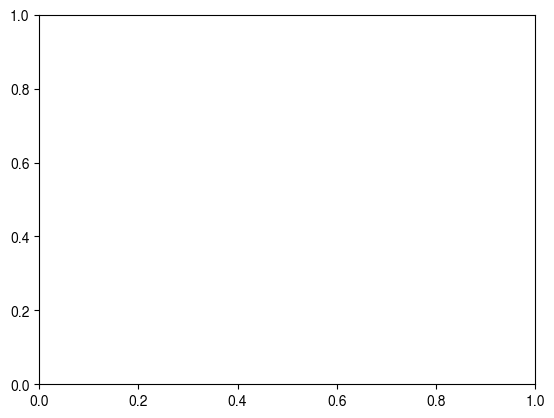

In [64]:
mc = "MC23a"
if inclusive_vertex == True: 
    vertexing = "Inclusive vertexing, "
else:
    vertexing = "Exclusive vertexing, "


#TrueDisp = LeadHadron_Truth_displacement
TrueDisp = MostTrackHadron_Truth_displacement

Truth_Displacement_x = TrueDisp[:, 0] 
Truth_Displacement_y = TrueDisp[:, 1] 
Truth_Displacement_z =TrueDisp[:, 2]

Truth_Lxy = np.sqrt( Truth_Displacement_x**2 + Truth_Displacement_y**2)


#My_Truth = Truth_Lxy

My_Truth = Lxy_truth_tracks

GN2_Residual =  Lxy - My_Truth
SV1_Residual =  jets["SV1_Lxy"] - My_Truth
JetFitter_Residual = jets["JetFitterSecondaryVertex_displacement2d"] - My_Truth 
Truth_Residual = Lxy_truth_tracks - My_Truth 
SuperTruth_Residual = Lxy_super_truth_tracks - My_Truth 


com = "13" if "MC20" in mc else "13.6"

normalise = False
extra_string = basic_extra_string
y_axis = "Number of jets"
if normalise: 
    extra_string = basic_extra_string+"_norm"
    y_axis = "Normalised number of vertices"


for flavour in ["bjets", "cjets"]:

    # Choose selection
    if flavour == "all":
        f = ""
        flav_str = "(all flavours)"
    
    if flavour == "bjets":
        f = "b"
        flav_str = "$b$-jets"
    
    if flavour == "cjets":
        f = "c"
        flav_str = "$c$-jets"
    
    if flavour == "light":
        f = "light"
        flav_str = "(light jets)"
    
    
    truth_hist_v0 = Histogram(jets["HadronConeExclTruthLabelLxy"][jet_flavour(jets, f)], label="Truth HadronConeExclTruthLabelLxy", histtype="step", alpha=1)
    #truth_hist = Histogram(Truth_Lxy[jet_flavour(jets, f)], label="Truth", histtype="step", alpha=1)
    gn2_hist =  Histogram(Lxy[jet_flavour(jets, f)], label="Vertex Fit (GN2 SV)", histtype="step", alpha=1)
    gn2_perfect_hist =  Histogram(Lxy_truth_tracks[jet_flavour(jets, f)], label="Vertex Fit (Truth SV)", histtype="step", alpha=1)
    gn2_super_perfect_hist =  Histogram(Lxy_super_truth_tracks[jet_flavour(jets, f)], label="Vertex Fit (Hadron Truth SV)", histtype="step", alpha=1)
    sv1_hist = Histogram(jets["SV1_Lxy"][jet_flavour(jets, f) ], label="SV1", histtype="step", alpha=1)
    JetFitter_hist = Histogram(jets["JetFitterSecondaryVertex_displacement2d"][jet_flavour(jets, f)], label="JetFitter", histtype="step", alpha=1)
        
        
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel=y_axis,
        xlabel="Lxy [mm]",
        logy=True,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=40,  # you can also define an integer number for the number of bins
        bins_range=(0,40),  # only considered if bins is an integer
        norm=normalise,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag=mc+" "+sample+" "+flav_str+extra,
        figsize=(6, 5),
        n_ratio_panels=1,
    )
    
    
    plot_histo.add(gn2_hist, reference=False)
    plot_histo.add(gn2_perfect_hist, reference=True)
    #plot_histo.add(gn2_super_perfect_hist, reference=False)
    plot_histo.add(sv1_hist, reference=False)
    plot_histo.add(JetFitter_hist, reference=False)
    #plot_histo.add(truth_hist, reference=True)


    plot_histo.draw()

    plot_histo.savefig(output+"Paper_Histogram_Lxy_"+flavour+extra_string+".png", transparent=False)


    normalise = True
    extra_string = basic_extra_string
    y_axis = "Number of jets"
    if normalise: 
        extra_string = basic_extra_string+"_norm"
        y_axis = "Normalised number of vertices"


    truth_hist = Histogram(Truth_Residual[jet_flavour(jets, f)], label="Truth SV Tracks", histtype="step", alpha=1, colour="black")
    gn2_hist =  Histogram(GN2_Residual[jet_flavour(jets, f)], label="GN2", histtype="step", alpha=1, colour="deepskyblue")
    gn2_super_perfect_hist =  Histogram(SuperTruth_Residual[jet_flavour(jets, f)], label="Truth", histtype="step", alpha=1, colour="red")
    sv1_hist = Histogram(SV1_Residual[jet_flavour(jets, f) ], label="SV1", histtype="step", alpha=1, colour="pink")
    JetFitter_hist = Histogram(JetFitter_Residual[jet_flavour(jets, f)], label="JetFitter", histtype="step", alpha=1, colour="green")
        
        
    # Initialise histogram plot
    plot_histo = HistogramPlot(
        ylabel=y_axis,
        xlabel="L$_{\mathrm{xy}}$ Residual [mm] (reco - truth)",
        logy=False,
        # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
        bins=9,  # you can also define an integer number for the number of bins
        bins_range=(-3.45,3.45),  # only considered if bins is an integer
        norm=normalise,
        atlas_first_tag="Simulation Internal",
        atlas_second_tag="$\\sqrt{s}=" + com + "$ TeV, " + mc + "\n" + sample_str + ", " + cut_str+" \n"+vertexing+flav_str,
        figsize=(6, 5),
        n_ratio_panels=0,
    )

    if inclusive_vertex == True: plot_histo.add(sv1_hist, reference=False)
    plot_histo.add(JetFitter_hist, reference=False)    
    plot_histo.add(gn2_hist, reference=False)
    #plot_histo.add(truth_hist, reference=True)


    plot_histo.draw()

    plot_histo.savefig(output+"Paper_Histogram_Lxy_Residual_"+flavour+extra_string+".png", transparent=False)
